# 0. 计算所有车 每秒行驶里程

In [4]:
import pandas as pd
from math import sin, asin, cos, radians, fabs, sqrt,pi,atan2,degrees,tan
import matplotlib.pyplot as plt

In [42]:
def hav(theta):
    s = sin(theta / 2)
    return s * s
 
def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS=6371           # 地球平均半径，6371km
    "用haversine公式计算球面两点间的距离。"
    # 经纬度转换成弧度
    lat0 = radians(lat0)
    lat1 = radians(lat1)
    lng0 = radians(lng0)
    lng1 = radians(lng1)
 
    dlng = fabs(lng0 - lng1)
    dlat = fabs(lat0 - lat1)
    h = hav(dlat) + cos(lat0) * cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * asin(sqrt(h))
 
    return distance
def set_distance(data):
    data.loc[:,'distance'] = 0
    length = data.shape[0]
    for i in range(1,length):
        lon1,lat1 = data.loc[i-1,'lng'] ,data.loc[i-1,'lat']
        lon2,lat2 = data.loc[i,'lng']   ,data.loc[i,'lat']
        d = get_distance_hav(lat1,lon1,lat2,lon2)
        data.loc[i,'distance'] = d
    
    return data

In [44]:
# 对 十个文件进行处理
files = ['AA00002', 'AB00006', 'AD00003', 'AD00013', 'AD00053' ,'AD00083' ,'AD00419', 'AF00098' ,'AF00131', 'AF00373']
for file in files:
    name = file+'.csv'
    data = pd.read_csv(name)
    distance_data = set_distance(data)
    output = file+'_DIS.csv'
    
    distance_data.to_csv(output)
    print('%s 已完成'%output)

AA00002_DIS.csv 已完成
AB00006_DIS.csv 已完成
AD00003_DIS.csv 已完成
AD00013_DIS.csv 已完成
AD00053_DIS.csv 已完成
AD00083_DIS.csv 已完成
AD00419_DIS.csv 已完成
AF00098_DIS.csv 已完成
AF00131_DIS.csv 已完成
AF00373_DIS.csv 已完成


# 1. 计算行车里程

In [208]:
def miles (data):
    length = data.shape[0]
    miles = data.loc[length-1,'mileage'] - data.loc[0,'mileage']
    return miles

# 2. 平均行车速度

In [209]:
def cal_mean_speed(data):
    # 汽车在走的 时间/秒
    move = (data['gps_speed'] != 0).astype(int).sum(axis=0)  # 更改 为 'gps_speed'=0  而不是distance =0 因为 后者有可能熄火滑行
    total_speed = data.sum(axis =0)['gps_speed']

    mean_speed = total_speed/move  #km/h
    return mean_speed



# 3. 计算10辆车 行车里程、平均速度

In [210]:
files = ['AA00002', 'AB00006', 'AD00003', 'AD00013', 'AD00053' ,'AD00083' ,'AD00419', 'AF00098' ,'AF00131', 'AF00373']
result = pd.DataFrame(columns = ['name','miles','mean_speed'])
i= 0
for file in files:
    name = file+ '_normal.csv'#'_DIS.csv' 
    data = pd.read_csv(name)
    
    mile = miles(data)
    mean_speed = cal_mean_speed(data)
    
#     print(mile,mean_speed)
    result.loc[i,'name'] = (name)
    result.loc[i,'miles'] = (mile)
    result.loc[i,'mean_speed'] = (mean_speed)

    print('%s 计算完成'%name)
    i+=1
    
result.to_csv('miles and speed of 10 cars_gps speed.csv')
result

AA00002_normal.csv 计算完成
AB00006_normal.csv 计算完成
AD00003_normal.csv 计算完成
AD00013_normal.csv 计算完成
AD00053_normal.csv 计算完成
AD00083_normal.csv 计算完成
AD00419_normal.csv 计算完成
AF00098_normal.csv 计算完成
AF00131_normal.csv 计算完成
AF00373_normal.csv 计算完成


,name,miles,mean_speed
0,AA00002_normal.csv,749,58.6317
1,AB00006_normal.csv,12200,38.8598
2,AD00003_normal.csv,15138,46.5281
3,AD00013_normal.csv,7565,39.3921
4,AD00053_normal.csv,779,50.2271
5,AD00083_normal.csv,814,41.7352
6,AD00419_normal.csv,4197,45.4393
7,AF00098_normal.csv,1032,50.2289
8,AF00131_normal.csv,703,38.9532
9,AF00373_normal.csv,2587,38.5077


# 4. 急加速急减速情况

## 4.1 计算加速度
考虑 时间！！！！！！！
好像没关系。 有时间间隔的 要么结束要么开始 v都是0

In [2]:
def acc_speed(v1,v2):
    return (v2-v1)

## 4.3 求解加速度，新建一列

In [3]:
# files = ['AA00002', 'AB00006', 'AD00003', 'AD00013', 'AD00053' ,'AD00083' ,'AD00419', 'AF00098' ,'AF00131', 'AF00373']
files = ['AA00002']
i= 0
for file in files:
    name = file+'_normal.csv'
    data = pd.read_csv(name)
    data['acc_speed'] = 0
    
    for i in range(1,data.shape[0]):
        v1 = data.loc[i-1,'gps_speed']
        v2 = data.loc[i,'gps_speed']
        if data.loc[i,'location_time'] - data.loc[i-1,'location_time'] >30:
            data.loc[i,'acc_speed']=0
        else:
            data.loc[i,'acc_speed'] = acc_speed(v1,v2)
    
    output = name +'_acc'
    data.to_csv(output , index = False)
    print('%s 计算完成'%name)
    i+=1



AA00002_normal.csv 计算完成


## 4.4 求解急加速急减速情况

In [23]:
def num_speed_up_down(data):
    
    acc_up = data[data['acc_speed']>=3].shape[0]
    acc_down = data[data['acc_speed']<=-3].shape[0]
    all_up = data[(data['acc_speed']>0)].shape[0]  # 所有加速情况  （有加速度为前提）
    all_down = data[(data['acc_speed']<0)].shape[0] #所有减速情况  （有加速度为前提）
    
    return acc_up,acc_down,all_up,all_down

In [24]:
files = ['AA00002', 'AB00006', 'AD00003', 'AD00013', 'AD00053' ,'AD00083' ,'AD00419', 'AF00098' ,'AF00131', 'AF00373']
result = pd.DataFrame(columns = ['name','speed_up','speed_down','speed_up_percent','speed_down_percent'])
i= 0
for file in files:
    name = file+'_DIS.csv'
    data = pd.read_csv(name)
    
    acc_up,acc_down,all_up,all_down =  num_speed_up_down(data)
    
    
    result.loc[i,'name'] = (name)
    result.loc[i,'speed_up'] = (acc_up)
    result.loc[i,'speed_down'] = (acc_down)
    result.loc[i,'speed_up_percent'] = (acc_down)/all_up
    result.loc[i,'speed_down_percent'] = (acc_down)/all_down

    print('%s 计算完成'%name)
    i+=1
    
result.to_csv('10 cars acc speed up and speed down.csv')
result

AA00002_DIS.csv 计算完成
AB00006_DIS.csv 计算完成
AD00003_DIS.csv 计算完成
AD00013_DIS.csv 计算完成
AD00053_DIS.csv 计算完成
AD00083_DIS.csv 计算完成
AD00419_DIS.csv 计算完成
AF00098_DIS.csv 计算完成
AF00131_DIS.csv 计算完成
AF00373_DIS.csv 计算完成


,name,speed_up,speed_down,speed_up_percent,speed_down_percent
0,AA00002_DIS.csv,1152,1902,0.153896,0.185236
1,AB00006_DIS.csv,5851,7058,0.186197,0.209791
2,AD00003_DIS.csv,1506,1901,0.185102,0.226687
3,AD00013_DIS.csv,6822,8346,0.218287,0.265466
4,AD00053_DIS.csv,3055,3579,0.206259,0.225506
5,AD00083_DIS.csv,3962,5048,0.21709,0.279111
6,AD00419_DIS.csv,1734,2348,0.153074,0.179073
7,AF00098_DIS.csv,2536,3708,0.159183,0.206677
8,AF00131_DIS.csv,1616,2030,0.126788,0.141129
9,AF00373_DIS.csv,2370,3892,0.187892,0.234232


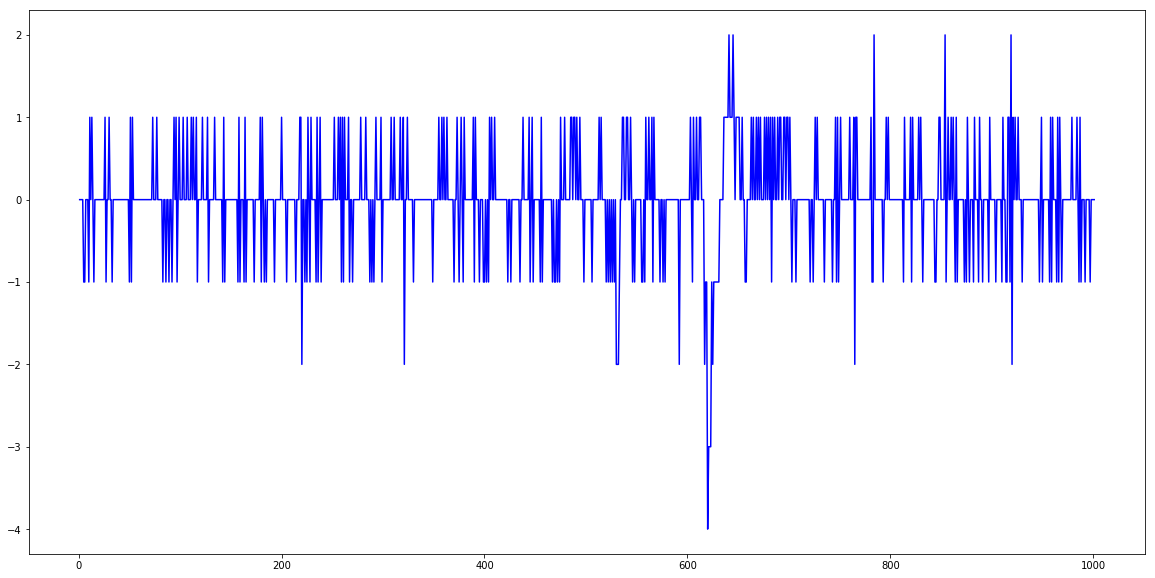

In [71]:
data = pd.read_csv('AA00002_normal.csv').loc[:1000,:]
data['acc_speed'] = 0
# 新建acc列    
for i in range(1,data.shape[0]):
    v1 = data.loc[i-1,'gps_speed']
    v2 = data.loc[i,'gps_speed']
    if data.loc[i,'location_time'] - data.loc[i-1,'location_time'] >30:
            data.loc[i,'acc_speed']=0
    else:
        data.loc[i,'acc_speed'] = acc_speed(v1,v2)
    

x = [i for i in range(1,data.shape[0]+1)]

acc_up = data[data['acc_speed']>=3]
index = acc_up.index

plt.figure(figsize = (20,10))
plt.plot(x,data['acc_speed'], c = 'b')

plt.scatter(index,acc_up['acc_speed'] , c = 'r',marker = '+')
plt.show()

# 5. 不良驾驶行为

## 5.1 熄火滑行
判断 acc_state 状态为0， 但是 distance != 0     
返回  熄火滑行次数、熄火滑行平均距离

In [50]:
def off_state_move(data):
    off_state = 0
    of_dis = 0
    for i in range(1,data.shape[0]):
        if (data.loc[i,'location_time'] - data.loc[i-1,'location_time']) <30:
            
            if data.loc[i,'acc_state']==0  and  data.loc[i,'distance'] != 0:
                off_state+=1
                off_dis = data.loc[i,'distance']
                print(i)
                print(data.loc[i,'location_time'],data.loc[i-1,'location_time'])
#     off_state = data[ (data['acc_state']==0 ) & ( data['distance'] != 0) ]  #熄火滑行数据
#     num_off = off_state.shape[0]   #熄火滑行次数
#     dis_off_mean = off_state['distance'].mean() #熄火滑行平均距离
    dis_off_mean = off_dis/off_state
    
#     print(num_off , dis_off_mean)
    return off_state , dis_off_mean    


In [51]:
data = pd.read_csv('AA00001_normal.csv')
off_state_move(data)

29341
1533494713 1533494712
55729
1533568358 1533568356


(2, 0.00022188118099585375)

## 5.2 急变道
判断  当 角速度值大于 0.45rad/s ， 速度超过 30km/h = 8.33 m /s = 0.0083 km/s时为紧急转弯     
转向角度 变化 公式 (>0)  ：  min( abs(x2-x1)  ,    (abs(abs(x2-x1)-360 ) %360)  )
返回：  急变道次数，急变道平均转向弧度

In [57]:
x1 = 258
x2 = 103
min( abs(x2-x1)  ,    (abs(abs(x2-x1)-360 ) %360)  )

155

### 5.2.1 新建一列求解 turn_angle——> rad

In [5]:
# 度转为弧度
def rad(d):
    return d * pi / 180.0
# 先 得到 turn angle 数据
def turn_angle(data):
    data.loc[0,'turn_angle'] = 0
    for i in range(1,data.shape[0]):
        x1 = data.loc[i-1,'direction_angle']
        x2 = data.loc[i,'direction_angle']
        turn_angle =  min( abs(x2-x1)  ,    (abs(abs(x2-x1)-360 ) %360)  )
        if data.loc[i,'location_time'] - data.loc[i-1,'location_time'] >30:
            data.loc[i,'turn_angle']=0
        else:
            data.loc[i,'turn_angle'] = rad(turn_angle)
    
    return data

In [59]:
# 再统计 急转弯次数、平均值
def is_sud_turn(data):
    
    sud_turn = data[ (data['gps_speed'] >=30 ) & ( data['turn_angle'] >= 0.45) ]  # 速度满足30  角度满足0.45
    
    num_sud = sud_turn.shape[0]
    mean_sud = sud_turn['turn_angle'].mean()
    
    return num_sud , mean_sud

In [6]:
data = pd.read_csv('AB00265_normal.csv')
data = turn_angle(data)
data.to_csv('AB00265_normal_angle.csv')
# num_sud , mean_sud = is_sud_turn(data)
# num_sud , mean_sud
plt.figure(figsize = (20,10))
plt.plot(x,data['turn_angle'] , c = 'b')
# plt.scatter(index,acc_up['acc_speed'] , c = 'r',marker = '+')
plt.show()

NameError: name 'x' is not defined

<Figure size 1440x720 with 0 Axes>

## 5.3 怠速预热、超长怠速
正常预热 30s -1min   
怠速预热 1min - 10min   
超长怠速 >10 min  
判断 acc_state =1 , distance =0 的时间    
返回：中间结果列表，怠速预热次数，超长怠速次数

In [48]:
data.to_csv('AB00006_DIS.csv',index = False)

In [28]:
def is_idle_preheat(data):
#     data['idle']=0 # 0 正常 1 怠速预热 2 超长怠速
    count = 0
    idle = 0  # 怠速预热次数
    long_idle = 0 #超长怠速次数
    
    res = []
    for i in range(1,data.shape[0]):
        if data.loc[i,'location_time'] - data.loc[i-1,'location_time'] <30:

            if ( data.loc[i,'distance'] ==0)  & ( data.loc[i,'acc_state'] ==1 ) :
                count +=1
                # 找 连续的 600段
            else:
                if count != 0:
                    res.append(count)
                if count > 600:
                    long_idle +=1
                elif count > 30:
                    idle +=1

                count =0
        else:
            count = 0

    return res,idle,long_idle
    

In [29]:
data = pd.read_csv('AB00265_normal.csv')
res,idle,long_idle = is_idle_preheat(data)
idle,long_idle

(20, 1)

## 5.4 疲劳驾驶

0. 判断上下条间隔是否 大于20分钟
1. 根据gps_speed 判断是在行驶还是休息 ??? 
2. 休息的时候判断 情况

In [30]:
#### 日累计驾驶时间 检测
def very_tired(data):
    
    tired_time = 0
    very_tired = 0   #一天行驶超过八小时 状态
    length = data.shape[0]
    
    start = data.loc[0,'location_time']
    start_index = 0
    end_index = ((data[  (data['location_time']-start) >  24*60*60 ].head(1).index.values)-1)[0]


    
     #一天的计算
    day = 1
    while end_index < length:  # not the last rec
    
    # 找 与 开始时刻相差 24h 的 结束时刻
        x = (data[  (data['location_time']-start) >  24*60*60 ].head(1).index.values)-1   
        end_index = x[0] if x else length # 上一阶段最后为 end 
        print('DAY%d'%day)#start_index,end_index

    
        total_drive = data[ data.loc[:, 'gps_speed'] !=0 ].loc[start_index:end_index,:].shape[0] 
        print(total_drive/60/60)            
                    
        # 一天结束后 ，判断 
        if total_drive >(7.5)*60*60 and total_drive < (8*60*60):
            tired_time +=1
        if total_drive > 8*60*60:  #一天超过8小时  ，疲劳驾驶t_totaldrive
            very_tired +=1
            
       
        
        # 一天结束后 清零

        total_drivee = 0
        # 开始新的一天
        try:
            start_index = end_index+1
            start = data.loc[start_index,'location_time']
        except:
            break
        day +=1
#     print(data[   data.loc[:, 'gps_speed'] !=0].shape[0]/60/60  )
            
# 返回 疲劳驾驶次数、 非常疲劳次数            
    return tired_time,very_tired
##############
# 计算 单次行驶 不应该分割天数，计算总行驶 分割天数


In [206]:
data = pd.read_csv('AA00002.csv')
very_tired(data)

DAY1
1.4236111111111112
DAY2
7.973611111111111
DAY3
2.1102777777777777
11.5075


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


(0, 1)

In [36]:
## 单次疲劳
def single_tired(data):
    t_rest = 0
    t_run = 0
    t_totaldrive = 0
    list_rest = []
    list_run = []
    tired_time = 0

    length = data.shape[0]
    
        
    for i in range(1,length):
        # 1. 判断两条数据是否相差20min   
        if (data.loc[i,'location_time'] - data.loc[i-1,'location_time']) >= 20*60:
                if t_run > 4*60*60: # 连续跑 4h ， 疲劳驾驶
                    tired_time +=1
                # clear params
                t_run = 0
                list_run =[]
                t_rest = 0
                list_rest = []
                    
        # 2. 判断是否在行驶
        if (data.loc[i,'gps_speed']==1) :   #driving :  acc = 1 & distance !=0  and (data.loc[i,'distance'] !=0 )

            t = data.loc[i,'location_time']
            list_run.append(t) 
            t_run = t- list_run[0]    #更新行驶时间
#             print('t_run: ',t_run/60/60)
            t_rest = 0                # 清空休息时间
            list_rest = []


        else:   #汽车休息

           
            t_r = data.loc[i,'location_time']   #更新休息时间
            list_rest.append(t_r)
            t_rest = t_r - list_rest[0]
#             print('t_rest: ',t_rest/60/60)
            
            if t_rest >= 20*60:  # 休息够20min
                if t_run > 4*60*60: # 连续跑 4h ， 疲劳驾驶
                    tired_time +=1
                    
                else:   #正常
                    pass


                t_run = 0
                list_run =[]
                t_rest = 0
                list_rest = []

            else:
                pass
    
    return tired_time 

In [189]:
single_tired(data)

t_run:  0.0
t_run:  0.0002777777777777778
t_run:  0.0005555555555555556
t_run:  0.0008333333333333334
t_run:  0.0011111111111111111
t_run:  0.0013888888888888887
t_run:  0.0016666666666666668
t_run:  0.0019444444444444444
t_run:  0.0022222222222222222
t_run:  0.0025
t_run:  0.0027777777777777775
t_run:  0.0030555555555555553
t_run:  0.0033333333333333335
t_run:  0.0036111111111111114
t_run:  0.0038888888888888888
t_run:  0.004166666666666667
t_run:  0.0044444444444444444
t_run:  0.004722222222222222
t_run:  0.005
t_run:  0.005277777777777778
t_run:  0.005555555555555555
t_run:  0.0061111111111111106
t_run:  0.006388888888888889
t_run:  0.006666666666666667
t_run:  0.006944444444444445
t_run:  0.007222222222222223
t_run:  0.007500000000000001
t_run:  0.0077777777777777776
t_run:  0.008055555555555555
t_run:  0.008333333333333333
t_run:  0.008611111111111113
t_run:  0.008888888888888889
t_run:  0.009166666666666667
t_run:  0.009444444444444445
t_run:  0.009722222222222222
t_run:  0.01
t_

t_run:  0.14472222222222222
t_run:  0.145
t_run:  0.14527777777777778
t_run:  0.14555555555555555
t_run:  0.14583333333333334
t_run:  0.14611111111111114
t_run:  0.14638888888888887
t_run:  0.14666666666666667
t_run:  0.14694444444444443
t_run:  0.14722222222222223
t_run:  0.1475
t_run:  0.14777777777777779
t_run:  0.14805555555555555
t_run:  0.14833333333333334
t_run:  0.1486111111111111
t_run:  0.1488888888888889
t_run:  0.14916666666666664
t_run:  0.14944444444444444
t_run:  0.1497222222222222
t_run:  0.15
t_run:  0.1502777777777778
t_run:  0.15055555555555555
t_run:  0.15083333333333335
t_run:  0.1511111111111111
t_run:  0.1513888888888889
t_run:  0.15166666666666667
t_run:  0.15194444444444447
t_run:  0.1522222222222222
t_run:  0.1525
t_run:  0.15277777777777776
t_run:  0.15305555555555556
t_run:  0.15333333333333332
t_run:  0.15361111111111111
t_run:  0.15388888888888888
t_run:  0.15416666666666667
t_run:  0.15444444444444447
t_run:  0.15472222222222223
t_run:  0.155
t_run:  0.15

t_run:  0.28500000000000003
t_run:  0.2852777777777778
t_run:  0.28555555555555556
t_run:  0.28583333333333333
t_run:  0.28611111111111115
t_run:  0.2863888888888889
t_run:  0.2866666666666667
t_run:  0.2869444444444444
t_run:  0.2872222222222222
t_run:  0.2875
t_run:  0.28777777777777774
t_run:  0.28805555555555556
t_run:  0.28833333333333333
t_run:  0.2886111111111111
t_run:  0.28888888888888886
t_run:  0.2891666666666667
t_run:  0.28944444444444445
t_run:  0.2897222222222222
t_run:  0.29
t_run:  0.2902777777777778
t_run:  0.29055555555555557
t_run:  0.29083333333333333
t_run:  0.2911111111111111
t_run:  0.2913888888888889
t_run:  0.2916666666666667
t_run:  0.29194444444444445
t_run:  0.29222222222222227
t_run:  0.29250000000000004
t_run:  0.29277777777777775
t_run:  0.2930555555555555
t_run:  0.29333333333333333
t_run:  0.2936111111111111
t_run:  0.29388888888888887
t_run:  0.29416666666666663
t_run:  0.29444444444444445
t_run:  0.2947222222222222
t_run:  0.295
t_run:  0.29527777777

t_run:  0.4244444444444444
t_run:  0.4247222222222222
t_run:  0.425
t_run:  0.42527777777777775
t_run:  0.4255555555555556
t_run:  0.42583333333333334
t_run:  0.4261111111111111
t_run:  0.4263888888888889
t_run:  0.4266666666666667
t_run:  0.42694444444444446
t_run:  0.4272222222222222
t_run:  0.4275
t_run:  0.4277777777777778
t_run:  0.4280555555555556
t_run:  0.42833333333333334
t_run:  0.4286111111111111
t_run:  0.42888888888888893
t_run:  0.42916666666666664
t_run:  0.4294444444444444
t_run:  0.4297222222222222
t_run:  0.43
t_run:  0.43027777777777776
t_run:  0.4305555555555555
t_run:  0.43083333333333335
t_run:  0.4311111111111111
t_run:  0.4313888888888889
t_run:  0.43166666666666664
t_run:  0.43194444444444446
t_run:  0.43222222222222223
t_run:  0.4325
t_run:  0.43277777777777776
t_run:  0.4330555555555556
t_run:  0.43333333333333335
t_run:  0.4336111111111111
t_run:  0.43388888888888894
t_run:  0.4341666666666667
t_run:  0.43444444444444447
t_run:  0.4347222222222222
t_run:  0.

t_run:  0.5647222222222222
t_run:  0.565
t_run:  0.5652777777777778
t_run:  0.5655555555555555
t_run:  0.5658333333333334
t_run:  0.5661111111111111
t_run:  0.5663888888888889
t_run:  0.5666666666666667
t_run:  0.5669444444444445
t_run:  0.5672222222222222
t_run:  0.5675
t_run:  0.5677777777777778
t_run:  0.5680555555555556
t_run:  0.5683333333333334
t_run:  0.5686111111111111
t_run:  0.5688888888888889
t_run:  0.5691666666666666
t_run:  0.5694444444444444
t_run:  0.5697222222222221
t_run:  0.5700000000000001
t_run:  0.5702777777777778
t_run:  0.5705555555555556
t_run:  0.5708333333333333
t_run:  0.5711111111111111
t_run:  0.5713888888888888
t_run:  0.5716666666666667
t_run:  0.5719444444444445
t_run:  0.5722222222222223
t_run:  0.5725
t_run:  0.5727777777777778
t_run:  0.5730555555555555
t_run:  0.5733333333333334
t_run:  0.5736111111111111
t_run:  0.5738888888888888
t_run:  0.5741666666666667
t_run:  0.5744444444444444
t_run:  0.5747222222222222
t_run:  0.575
t_run:  0.57527777777777

t_run:  0.7052777777777778
t_run:  0.7055555555555556
t_run:  0.7058333333333333
t_run:  0.7061111111111111
t_run:  0.7063888888888888
t_run:  0.7066666666666667
t_run:  0.7069444444444444
t_run:  0.7072222222222222
t_run:  0.7075
t_run:  0.7077777777777778
t_run:  0.7080555555555555
t_run:  0.7083333333333334
t_run:  0.7086111111111111
t_run:  0.7088888888888889
t_run:  0.7091666666666666
t_run:  0.7094444444444445
t_run:  0.7097222222222223
t_run:  0.7100000000000001
t_run:  0.7102777777777778
t_run:  0.7105555555555555
t_run:  0.7108333333333333
t_run:  0.711111111111111
t_run:  0.7113888888888888
t_run:  0.7116666666666667
t_run:  0.7119444444444445
t_run:  0.7122222222222222
t_run:  0.7125
t_run:  0.7127777777777777
t_run:  0.7130555555555556
t_run:  0.7133333333333333
t_run:  0.7136111111111112
t_run:  0.7138888888888889
t_run:  0.7141666666666667
t_run:  0.7144444444444444
t_run:  0.7147222222222223
t_run:  0.715
t_run:  0.7152777777777778
t_run:  0.7155555555555555
t_run:  0.71

t_run:  0.8458333333333333
t_run:  0.8461111111111111
t_run:  0.8463888888888889
t_run:  0.8466666666666666
t_run:  0.8469444444444445
t_run:  0.8472222222222222
t_run:  0.8475
t_run:  0.8477777777777777
t_run:  0.8480555555555556
t_run:  0.8483333333333333
t_run:  0.8486111111111111
t_run:  0.8488888888888888
t_run:  0.8491666666666667
t_run:  0.8494444444444444
t_run:  0.8497222222222223
t_run:  0.8502777777777778
t_run:  0.8505555555555555
t_run:  0.8508333333333333
t_run:  0.8511111111111112
t_run:  0.851388888888889
t_run:  0.8516666666666667
t_run:  0.8519444444444445
t_run:  0.8522222222222222
t_run:  0.8524999999999999
t_run:  0.8527777777777777
t_run:  0.8530555555555555
t_run:  0.8533333333333334
t_run:  0.8536111111111111
t_run:  0.8538888888888889
t_run:  0.8541666666666666
t_run:  0.8544444444444445
t_run:  0.8547222222222222
t_run:  0.855
t_run:  0.8552777777777778
t_run:  0.8555555555555556
t_run:  0.8558333333333333
t_run:  0.8561111111111112
t_run:  0.8563888888888889


t_run:  0.986111111111111
t_run:  0.9863888888888889
t_run:  0.9866666666666667
t_run:  0.9869444444444445
t_run:  0.9872222222222222
t_run:  0.9875
t_run:  0.9877777777777778
t_run:  0.9880555555555556
t_run:  0.9883333333333333
t_run:  0.9886111111111112
t_run:  0.9888888888888889
t_run:  0.9891666666666666
t_run:  0.9894444444444445
t_run:  0.9897222222222222
t_run:  0.99
t_run:  0.9902777777777777
t_run:  0.9905555555555555
t_run:  0.9908333333333333
t_run:  0.9911111111111112
t_run:  0.9913888888888889
t_run:  0.9916666666666667
t_run:  0.9919444444444444
t_run:  0.9922222222222222
t_run:  0.9924999999999999
t_run:  0.9927777777777779
t_run:  0.9930555555555556
t_run:  0.9933333333333334
t_run:  0.9936111111111111
t_run:  0.9938888888888889
t_run:  0.9941666666666666
t_run:  0.9944444444444444
t_run:  0.9947222222222222
t_run:  0.995
t_run:  0.9952777777777778
t_run:  0.9955555555555555
t_run:  0.9958333333333333
t_run:  0.9961111111111111
t_run:  0.9963888888888889
t_run:  0.9966

t_run:  1.1263888888888889
t_run:  1.1266666666666665
t_run:  1.1269444444444443
t_run:  1.1272222222222223
t_run:  1.1275000000000002
t_run:  1.1277777777777778
t_run:  1.1280555555555556
t_run:  1.1283333333333334
t_run:  1.1286111111111112
t_run:  1.1288888888888888
t_run:  1.1291666666666667
t_run:  1.1294444444444445
t_run:  1.1297222222222223
t_run:  1.13
t_run:  1.1302777777777777
t_run:  1.1305555555555555
t_run:  1.1308333333333331
t_run:  1.131111111111111
t_run:  1.131388888888889
t_run:  1.1316666666666668
t_run:  1.1319444444444444
t_run:  1.1322222222222222
t_run:  1.1325
t_run:  1.1327777777777779
t_run:  1.1330555555555555
t_run:  1.1333333333333333
t_run:  1.1336111111111111
t_run:  1.133888888888889
t_run:  1.1341666666666665
t_run:  1.1344444444444444
t_run:  1.1347222222222222
t_run:  1.135
t_run:  1.1352777777777776
t_run:  1.1355555555555557
t_run:  1.1358333333333335
t_run:  1.1361111111111113
t_run:  1.136388888888889
t_run:  1.1366666666666667
t_run:  1.1369444

t_run:  1.2680555555555555
t_run:  1.2683333333333333
t_run:  1.268611111111111
t_run:  1.268888888888889
t_run:  1.2691666666666668
t_run:  1.2694444444444446
t_run:  1.2697222222222222
t_run:  1.27
t_run:  1.2702777777777778
t_run:  1.2705555555555557
t_run:  1.2708333333333333
t_run:  1.271111111111111
t_run:  1.271388888888889
t_run:  1.2716666666666667
t_run:  1.2719444444444443
t_run:  1.2722222222222221
t_run:  1.2725
t_run:  1.2727777777777776
t_run:  1.2730555555555556
t_run:  1.2733333333333334
t_run:  1.2736111111111112
t_run:  1.2738888888888888
t_run:  1.2741666666666667
t_run:  1.2744444444444445
t_run:  1.2747222222222223
t_run:  1.275
t_run:  1.2752777777777777
t_run:  1.2755555555555556
t_run:  1.2758333333333334
t_run:  1.276111111111111
t_run:  1.2763888888888888
t_run:  1.2766666666666666
t_run:  1.2769444444444444
t_run:  1.2772222222222223
t_run:  1.2775
t_run:  1.277777777777778
t_run:  1.2780555555555557
t_run:  1.2783333333333333
t_run:  1.2786111111111111
t_ru

t_run:  1.4072222222222224
t_run:  1.4075
t_run:  1.4077777777777778
t_run:  1.4080555555555556
t_run:  1.4083333333333334
t_run:  1.408611111111111
t_run:  1.4088888888888889
t_run:  1.4091666666666667
t_run:  1.4094444444444443
t_run:  1.409722222222222
t_run:  1.41
t_run:  1.4102777777777777
t_run:  1.4105555555555556
t_run:  1.4108333333333334
t_run:  1.4111111111111112
t_run:  1.411388888888889
t_run:  1.4116666666666666
t_run:  1.4119444444444444
t_run:  1.4122222222222223
t_run:  1.4125
t_run:  1.4127777777777777
t_run:  1.4130555555555555
t_run:  1.4133333333333333
t_run:  1.4136111111111112
t_run:  1.4138888888888888
t_run:  1.4141666666666666
t_run:  1.4144444444444444
t_run:  1.4147222222222224
t_run:  1.415
t_run:  1.4152777777777779
t_run:  1.4155555555555557
t_run:  1.4158333333333333
t_run:  1.416111111111111
t_run:  1.416388888888889
t_run:  1.4166666666666667
t_run:  1.4169444444444443
t_run:  1.4172222222222222
t_run:  1.4175
t_run:  1.4177777777777778
t_run:  1.41805

t_run:  1.5483333333333333
t_run:  1.5486111111111112
t_run:  1.548888888888889
t_run:  1.5491666666666668
t_run:  1.5494444444444444
t_run:  1.5497222222222222
t_run:  1.55
t_run:  1.5502777777777779
t_run:  1.5505555555555555
t_run:  1.5508333333333333
t_run:  1.551111111111111
t_run:  1.5513888888888887
t_run:  1.5516666666666665
t_run:  1.5519444444444443
t_run:  1.5522222222222224
t_run:  1.5525
t_run:  1.5527777777777778
t_run:  1.5530555555555556
t_run:  1.5533333333333335
t_run:  1.553611111111111
t_run:  1.5538888888888889
t_run:  1.5541666666666667
t_run:  1.5544444444444445
t_run:  1.5547222222222221
t_run:  1.555
t_run:  1.5552777777777778
t_run:  1.5555555555555556
t_run:  1.5558333333333332
t_run:  1.556111111111111
t_run:  1.556388888888889
t_run:  1.5566666666666669
t_run:  1.5569444444444445
t_run:  1.5572222222222223
t_run:  1.5575
t_run:  1.5577777777777777
t_run:  1.5580555555555555
t_run:  1.5583333333333333
t_run:  1.5586111111111112
t_run:  1.5588888888888888
t_r

t_run:  1.688611111111111
t_run:  1.6888888888888889
t_run:  1.6891666666666665
t_run:  1.6894444444444443
t_run:  1.6897222222222223
t_run:  1.6900000000000002
t_run:  1.6902777777777778
t_run:  1.6905555555555556
t_run:  1.6908333333333334
t_run:  1.6911111111111112
t_run:  1.6913888888888888
t_run:  1.6916666666666667
t_run:  1.6919444444444445
t_run:  1.6922222222222223
t_run:  1.6925
t_run:  1.6927777777777777
t_run:  1.6933333333333331
t_run:  1.693611111111111
t_run:  1.693888888888889
t_run:  1.6941666666666668
t_run:  1.6944444444444444
t_run:  1.6947222222222222
t_run:  1.695
t_run:  1.6952777777777779
t_run:  1.6955555555555555
t_run:  1.6958333333333333
t_run:  1.6961111111111111
t_run:  1.696388888888889
t_run:  1.6966666666666665
t_run:  1.6969444444444444
t_run:  1.6972222222222222
t_run:  1.6975
t_run:  1.6977777777777776
t_run:  1.6980555555555557
t_run:  1.6983333333333335
t_run:  1.6986111111111113
t_run:  1.698888888888889
t_run:  1.6991666666666667
t_run:  1.699444

t_run:  1.8291666666666666
t_run:  1.8294444444444444
t_run:  1.8297222222222222
t_run:  1.8299999999999998
t_run:  1.8302777777777777
t_run:  1.8305555555555555
t_run:  1.8308333333333333
t_run:  1.831111111111111
t_run:  1.831388888888889
t_run:  1.8316666666666668
t_run:  1.8319444444444446
t_run:  1.8322222222222222
t_run:  1.8325
t_run:  1.8327777777777778
t_run:  1.8330555555555557
t_run:  1.8333333333333333
t_run:  1.833611111111111
t_run:  1.833888888888889
t_run:  1.8341666666666667
t_run:  1.8344444444444443
t_run:  1.8347222222222221
t_run:  1.835
t_run:  1.8358333333333334
t_run:  1.8361111111111112
t_run:  1.8363888888888888
t_run:  1.8366666666666667
t_run:  1.8369444444444445
t_run:  1.8372222222222223
t_run:  1.8375
t_run:  1.8377777777777777
t_run:  1.8380555555555556
t_run:  1.8383333333333334
t_run:  1.838611111111111
t_run:  1.8388888888888888
t_run:  1.8391666666666666
t_run:  1.8394444444444444
t_run:  1.8397222222222223
t_run:  1.84
t_run:  1.840277777777778
t_ru

t_rest:  0.0077777777777777776
t_rest:  0.008055555555555555
t_rest:  0.008333333333333333
t_rest:  0.008611111111111113
t_rest:  0.008888888888888889
t_rest:  0.009166666666666667
t_rest:  0.009444444444444445
t_rest:  0.009722222222222222
t_rest:  0.01
t_rest:  0.010277777777777778
t_rest:  0.010555555555555556
t_rest:  0.010833333333333334
t_rest:  0.01111111111111111
t_rest:  0.01138888888888889
t_rest:  0.011666666666666665
t_rest:  0.011944444444444445
t_rest:  0.012222222222222221
t_rest:  0.0125
t_rest:  0.012777777777777779
t_rest:  0.013055555555555555
t_rest:  0.013333333333333334
t_rest:  0.01361111111111111
t_rest:  0.01388888888888889
t_rest:  0.014166666666666666
t_rest:  0.014444444444444446
t_rest:  0.014722222222222222
t_rest:  0.015000000000000001
t_rest:  0.015277777777777777
t_rest:  0.015555555555555555
t_rest:  0.01583333333333333
t_rest:  0.01611111111111111
t_rest:  0.016388888888888887
t_rest:  0.016666666666666666
t_rest:  0.016944444444444443
t_rest:  0.0172

t_run:  0.08611111111111111
t_run:  0.08638888888888889
t_run:  0.08666666666666667
t_run:  0.08694444444444445
t_run:  0.08722222222222223
t_run:  0.0875
t_run:  0.08805555555555555
t_run:  0.08861111111111111
t_run:  0.08888888888888888
t_run:  0.08916666666666666
t_run:  0.08944444444444444
t_run:  0.08972222222222223
t_run:  0.09000000000000001
t_run:  0.09027777777777778
t_run:  0.09055555555555556
t_run:  0.09083333333333334
t_run:  0.09111111111111111
t_run:  0.0913888888888889
t_run:  0.09166666666666666
t_run:  0.09194444444444444
t_run:  0.09222222222222222
t_run:  0.0925
t_run:  0.09277777777777778
t_run:  0.09305555555555554
t_run:  0.09333333333333332
t_run:  0.0936111111111111
t_run:  0.0938888888888889
t_run:  0.09416666666666668
t_run:  0.09444444444444446
t_run:  0.09472222222222222
t_run:  0.095
t_run:  0.09527777777777778
t_run:  0.09555555555555556
t_run:  0.09583333333333334
t_run:  0.0961111111111111
t_run:  0.09638888888888889
t_run:  0.09666666666666666
t_run:  

t_run:  0.22666666666666666
t_run:  0.22694444444444445
t_run:  0.22722222222222221
t_run:  0.2275
t_run:  0.22777777777777777
t_run:  0.22805555555555557
t_run:  0.22833333333333333
t_run:  0.22861111111111113
t_run:  0.22888888888888886
t_run:  0.22916666666666666
t_run:  0.22944444444444445
t_run:  0.22972222222222222
t_run:  0.23
t_run:  0.23027777777777778
t_run:  0.23055555555555557
t_run:  0.23083333333333333
t_run:  0.23111111111111113
t_run:  0.2313888888888889
t_run:  0.23166666666666666
t_run:  0.23194444444444443
t_run:  0.23222222222222222
t_run:  0.23249999999999998
t_run:  0.23277777777777778
t_run:  0.23305555555555554
t_run:  0.23333333333333334
t_run:  0.23361111111111113
t_run:  0.2338888888888889
t_run:  0.2341666666666667
t_run:  0.23444444444444443
t_run:  0.23472222222222222
t_run:  0.235
t_run:  0.23527777777777778
t_run:  0.23555555555555555
t_run:  0.23583333333333334
t_run:  0.2361111111111111
t_run:  0.2363888888888889
t_run:  0.23666666666666666
t_run:  0.2

t_run:  0.3675
t_run:  0.36777777777777776
t_run:  0.3680555555555555
t_run:  0.36833333333333335
t_run:  0.3686111111111111
t_run:  0.3688888888888889
t_run:  0.36916666666666664
t_run:  0.36944444444444446
t_run:  0.36972222222222223
t_run:  0.37
t_run:  0.37027777777777776
t_run:  0.3705555555555556
t_run:  0.37083333333333335
t_run:  0.3711111111111111
t_run:  0.37138888888888894
t_run:  0.3716666666666667
t_run:  0.37194444444444447
t_run:  0.3722222222222222
t_run:  0.3725
t_run:  0.37277777777777776
t_run:  0.37305555555555553
t_run:  0.3733333333333333
t_run:  0.3736111111111111
t_run:  0.3738888888888889
t_run:  0.37416666666666665
t_run:  0.3744444444444444
t_run:  0.37472222222222223
t_run:  0.375
t_run:  0.37527777777777777
t_run:  0.3755555555555556
t_run:  0.37583333333333335
t_run:  0.3761111111111111
t_run:  0.3763888888888889
t_run:  0.3766666666666667
t_run:  0.37694444444444447
t_run:  0.37722222222222224
t_run:  0.3775
t_run:  0.3777777777777778
t_run:  0.3780555555

t_run:  0.5072222222222222
t_run:  0.5075
t_run:  0.5077777777777778
t_run:  0.5080555555555556
t_run:  0.5083333333333333
t_run:  0.5086111111111111
t_run:  0.508888888888889
t_run:  0.5091666666666667
t_run:  0.5094444444444445
t_run:  0.5097222222222222
t_run:  0.51
t_run:  0.5102777777777778
t_run:  0.5105555555555555
t_run:  0.5108333333333334
t_run:  0.5111111111111112
t_run:  0.5113888888888889
t_run:  0.5116666666666666
t_run:  0.5119444444444444
t_run:  0.5122222222222222
t_run:  0.5125
t_run:  0.5127777777777778
t_run:  0.5130555555555556
t_run:  0.5133333333333333
t_run:  0.5136111111111111
t_run:  0.5138888888888888
t_run:  0.5141666666666667
t_run:  0.5144444444444445
t_run:  0.5147222222222222
t_run:  0.515
t_run:  0.5152777777777778
t_run:  0.5158333333333334
t_run:  0.5161111111111111
t_run:  0.5163888888888889
t_run:  0.5166666666666667
t_run:  0.5169444444444444
t_run:  0.5172222222222222
t_run:  0.5175
t_run:  0.5177777777777778
t_run:  0.5180555555555555
t_run:  0.5

t_run:  0.6477777777777778
t_run:  0.6480555555555555
t_run:  0.6483333333333333
t_run:  0.648611111111111
t_run:  0.6488888888888888
t_run:  0.6491666666666667
t_run:  0.6494444444444445
t_run:  0.6497222222222222
t_run:  0.65
t_run:  0.6502777777777777
t_run:  0.6505555555555556
t_run:  0.6508333333333333
t_run:  0.6511111111111112
t_run:  0.6513888888888889
t_run:  0.6516666666666667
t_run:  0.6519444444444444
t_run:  0.6522222222222223
t_run:  0.6525
t_run:  0.6527777777777778
t_run:  0.6530555555555555
t_run:  0.6533333333333334
t_run:  0.6536111111111111
t_run:  0.6538888888888889
t_run:  0.6541666666666667
t_run:  0.6544444444444444
t_run:  0.6547222222222222
t_run:  0.6549999999999999
t_run:  0.6552777777777778
t_run:  0.6555555555555556
t_run:  0.6558333333333334
t_run:  0.6561111111111111
t_run:  0.6563888888888889
t_run:  0.6566666666666666
t_run:  0.6569444444444444
t_run:  0.6572222222222222
t_run:  0.6575000000000001
t_run:  0.6577777777777778
t_run:  0.6580555555555556
t

t_run:  0.7880555555555555
t_run:  0.7883333333333333
t_run:  0.7886111111111112
t_run:  0.788888888888889
t_run:  0.7891666666666667
t_run:  0.7894444444444445
t_run:  0.7897222222222222
t_run:  0.7899999999999999
t_run:  0.7902777777777777
t_run:  0.7905555555555555
t_run:  0.7908333333333334
t_run:  0.7911111111111111
t_run:  0.7913888888888889
t_run:  0.7916666666666666
t_run:  0.7919444444444445
t_run:  0.7922222222222222
t_run:  0.7925
t_run:  0.7927777777777778
t_run:  0.7930555555555556
t_run:  0.7933333333333333
t_run:  0.7936111111111112
t_run:  0.7938888888888889
t_run:  0.7941666666666667
t_run:  0.7944444444444444
t_run:  0.7947222222222222
t_run:  0.795
t_run:  0.7952777777777779
t_run:  0.7955555555555556
t_run:  0.7958333333333333
t_run:  0.7961111111111111
t_run:  0.7963888888888888
t_run:  0.7966666666666666
t_run:  0.7969444444444445
t_run:  0.7972222222222223
t_run:  0.7975
t_run:  0.7977777777777778
t_run:  0.7980555555555555
t_run:  0.7983333333333333
t_run:  0.79

t_run:  0.9591666666666666
t_run:  0.9594444444444445
t_run:  0.9597222222222223
t_run:  0.9600000000000001
t_run:  0.9602777777777778
t_run:  0.9605555555555555
t_run:  0.9608333333333333
t_run:  0.961111111111111
t_run:  0.9613888888888888
t_run:  0.9616666666666667
t_run:  0.9619444444444445
t_run:  0.9622222222222222
t_run:  0.9625
t_run:  0.9627777777777777
t_run:  0.9630555555555556
t_run:  0.9633333333333333
t_run:  0.9636111111111112
t_run:  0.9638888888888889
t_run:  0.9641666666666667
t_run:  0.9644444444444444
t_run:  0.9647222222222223
t_run:  0.965
t_run:  0.9652777777777778
t_run:  0.9655555555555555
t_run:  0.9658333333333334
t_run:  0.9661111111111111
t_run:  0.9663888888888889
t_run:  0.9666666666666667
t_run:  0.9669444444444444
t_run:  0.9672222222222222
t_run:  0.9674999999999999
t_run:  0.9677777777777778
t_run:  0.9680555555555556
t_run:  0.9683333333333334
t_run:  0.9686111111111111
t_run:  0.9688888888888889
t_run:  0.9691666666666666
t_run:  0.9694444444444444


t_run:  1.0997222222222223
t_run:  1.1
t_run:  1.1002777777777777
t_run:  1.1005555555555555
t_run:  1.1008333333333333
t_run:  1.1011111111111112
t_run:  1.1013888888888888
t_run:  1.1016666666666666
t_run:  1.1019444444444444
t_run:  1.1022222222222224
t_run:  1.1025
t_run:  1.1027777777777779
t_run:  1.1030555555555557
t_run:  1.1033333333333333
t_run:  1.103611111111111
t_run:  1.103888888888889
t_run:  1.1041666666666667
t_run:  1.1044444444444443
t_run:  1.1047222222222222
t_run:  1.105
t_run:  1.1052777777777778
t_run:  1.1055555555555554
t_run:  1.1058333333333332
t_run:  1.106111111111111
t_run:  1.106388888888889
t_run:  1.1066666666666667
t_run:  1.1069444444444445
t_run:  1.1072222222222223
t_run:  1.1075000000000002
t_run:  1.1077777777777778
t_run:  1.1080555555555556
t_run:  1.1083333333333334
t_run:  1.108611111111111
t_run:  1.1088888888888888
t_run:  1.1091666666666666
t_run:  1.1094444444444445
t_run:  1.109722222222222
t_run:  1.1099999999999999
t_run:  1.1102777777

t_run:  1.2394444444444443
t_run:  1.2397222222222224
t_run:  1.24
t_run:  1.2402777777777778
t_run:  1.2405555555555556
t_run:  1.2408333333333335
t_run:  1.241111111111111
t_run:  1.2413888888888889
t_run:  1.2416666666666667
t_run:  1.2422222222222221
t_run:  1.2425
t_run:  1.2427777777777778
t_run:  1.2430555555555556
t_run:  1.2433333333333332
t_run:  1.243611111111111
t_run:  1.243888888888889
t_run:  1.2441666666666669
t_run:  1.2444444444444445
t_run:  1.2447222222222223
t_run:  1.245
t_run:  1.2452777777777777
t_run:  1.2455555555555555
t_run:  1.2458333333333333
t_run:  1.2461111111111112
t_run:  1.2463888888888888
t_run:  1.2466666666666666
t_run:  1.2469444444444444
t_run:  1.2472222222222222
t_run:  1.2474999999999998
t_run:  1.2477777777777777
t_run:  1.2480555555555557
t_run:  1.2483333333333335
t_run:  1.2486111111111111
t_run:  1.248888888888889
t_run:  1.2491666666666668
t_run:  1.2494444444444446
t_run:  1.2497222222222222
t_run:  1.25
t_run:  1.2502777777777778
t_ru

t_run:  1.3802777777777777
t_run:  1.3805555555555555
t_run:  1.3808333333333331
t_run:  1.381111111111111
t_run:  1.381388888888889
t_run:  1.3816666666666668
t_run:  1.3819444444444444
t_run:  1.3822222222222222
t_run:  1.3825
t_run:  1.3827777777777779
t_run:  1.3830555555555555
t_run:  1.3833333333333333
t_run:  1.3836111111111111
t_run:  1.383888888888889
t_run:  1.3841666666666665
t_run:  1.3844444444444444
t_run:  1.3847222222222222
t_run:  1.385
t_run:  1.3852777777777776
t_run:  1.3855555555555557
t_run:  1.3858333333333335
t_run:  1.3861111111111113
t_run:  1.386388888888889
t_run:  1.3866666666666667
t_run:  1.3869444444444445
t_run:  1.3872222222222221
t_run:  1.3875
t_run:  1.3877777777777778
t_run:  1.3880555555555556
t_run:  1.3883333333333332
t_run:  1.388611111111111
t_run:  1.3888888888888888
t_run:  1.3891666666666667
t_run:  1.3894444444444443
t_run:  1.3897222222222223
t_run:  1.3900000000000001
t_run:  1.390277777777778
t_run:  1.3905555555555555
t_run:  1.3908333

t_run:  1.5208333333333333
t_run:  1.521111111111111
t_run:  1.521388888888889
t_run:  1.5216666666666667
t_run:  1.5219444444444443
t_run:  1.5222222222222221
t_run:  1.5225
t_run:  1.5227777777777776
t_run:  1.5230555555555556
t_run:  1.5233333333333334
t_run:  1.5236111111111112
t_run:  1.5238888888888888
t_run:  1.5241666666666667
t_run:  1.5244444444444445
t_run:  1.5247222222222223
t_run:  1.525
t_run:  1.5252777777777777
t_run:  1.5255555555555556
t_run:  1.5258333333333334
t_run:  1.526111111111111
t_run:  1.5263888888888888
t_run:  1.5266666666666666
t_run:  1.5269444444444444
t_run:  1.5272222222222223
t_run:  1.5275
t_run:  1.527777777777778
t_run:  1.5280555555555557
t_run:  1.5283333333333333
t_run:  1.5286111111111111
t_run:  1.528888888888889
t_run:  1.5291666666666666
t_run:  1.5294444444444444
t_run:  1.5297222222222222
t_run:  1.53
t_run:  1.5302777777777776
t_run:  1.5305555555555554
t_run:  1.5308333333333333
t_run:  1.531111111111111
t_run:  1.531388888888889
t_run

t_run:  1.661388888888889
t_run:  1.6616666666666666
t_run:  1.6619444444444444
t_run:  1.6622222222222223
t_run:  1.6625
t_run:  1.6627777777777777
t_run:  1.6630555555555555
t_run:  1.6633333333333333
t_run:  1.6636111111111112
t_run:  1.6638888888888888
t_run:  1.6641666666666666
t_run:  1.6644444444444444
t_run:  1.6647222222222224
t_run:  1.665
t_run:  1.6652777777777779
t_run:  1.6655555555555557
t_run:  1.6658333333333333
t_run:  1.666111111111111
t_run:  1.666388888888889
t_run:  1.6666666666666667
t_run:  1.6669444444444443
t_run:  1.6672222222222222
t_run:  1.6675
t_run:  1.6677777777777778
t_run:  1.6680555555555554
t_run:  1.6683333333333332
t_run:  1.668611111111111
t_run:  1.668888888888889
t_run:  1.6691666666666667
t_run:  1.6694444444444445
t_run:  1.6697222222222223
t_run:  1.6700000000000002
t_run:  1.6702777777777778
t_run:  1.6705555555555556
t_run:  1.6708333333333334
t_run:  1.671111111111111
t_run:  1.6713888888888888
t_run:  1.6716666666666666
t_run:  1.6719444

t_run:  1.8019444444444443
t_run:  1.8022222222222224
t_run:  1.8025
t_run:  1.8027777777777778
t_run:  1.8030555555555556
t_run:  1.8033333333333335
t_run:  1.803611111111111
t_run:  1.8038888888888889
t_run:  1.8041666666666667
t_run:  1.8044444444444445
t_run:  1.8047222222222221
t_run:  1.805
t_run:  1.8052777777777778
t_run:  1.8055555555555556
t_run:  1.8058333333333332
t_run:  1.806111111111111
t_run:  1.806388888888889
t_run:  1.8066666666666669
t_run:  1.8069444444444445
t_run:  1.8072222222222223
t_run:  1.8075
t_run:  1.8077777777777777
t_run:  1.8080555555555555
t_run:  1.8083333333333333
t_run:  1.8086111111111112
t_run:  1.8088888888888888
t_run:  1.8091666666666666
t_run:  1.8097222222222222
t_run:  1.8099999999999998
t_run:  1.8102777777777777
t_run:  1.8105555555555557
t_run:  1.8108333333333335
t_run:  1.8111111111111111
t_run:  1.811388888888889
t_run:  1.8116666666666668
t_run:  1.8119444444444446
t_run:  1.8122222222222222
t_run:  1.8125
t_run:  1.8127777777777778


t_run:  2.0130555555555554
t_run:  2.013333333333333
t_run:  2.013611111111111
t_run:  2.013888888888889
t_run:  2.0141666666666667
t_run:  2.0144444444444445
t_run:  2.0147222222222223
t_run:  2.015
t_run:  2.015277777777778
t_run:  2.0155555555555558
t_run:  2.0158333333333336
t_run:  2.016111111111111
t_run:  2.016388888888889
t_run:  2.0166666666666666
t_run:  2.0169444444444444
t_run:  2.0172222222222222
t_run:  2.0175
t_run:  2.017777777777778
t_run:  2.0180555555555553
t_run:  2.018333333333333
t_run:  2.018611111111111
t_run:  2.018888888888889
t_run:  2.0191666666666666
t_run:  2.0194444444444444
t_run:  2.019722222222222
t_run:  2.02
t_run:  2.020277777777778
t_run:  2.0205555555555557
t_run:  2.0208333333333335
t_run:  2.0211111111111113
t_run:  2.0213888888888887
t_run:  2.0216666666666665
t_run:  2.0219444444444443
t_run:  2.022222222222222
t_run:  2.0225
t_run:  2.022777777777778
t_run:  2.0230555555555556
t_run:  2.0233333333333334
t_run:  2.0236111111111112
t_run:  2.02

t_run:  2.2230555555555553
t_run:  2.2233333333333336
t_run:  2.223611111111111
t_run:  2.223888888888889
t_run:  2.2241666666666666
t_run:  2.2244444444444444
t_run:  2.224722222222222
t_run:  2.225
t_run:  2.225277777777778
t_run:  2.2255555555555557
t_run:  2.2258333333333336
t_run:  2.226111111111111
t_run:  2.226388888888889
t_run:  2.2269444444444444
t_run:  2.227222222222222
t_run:  2.2275
t_run:  2.2277777777777774
t_run:  2.2280555555555557
t_run:  2.228333333333333
t_run:  2.2286111111111113
t_run:  2.2288888888888887
t_run:  2.2291666666666665
t_run:  2.229444444444445
t_run:  2.229722222222222
t_run:  2.23
t_run:  2.230277777777778
t_run:  2.2305555555555556
t_run:  2.2308333333333334
t_run:  2.2311111111111113
t_run:  2.2313888888888886
t_run:  2.231666666666667
t_run:  2.2319444444444443
t_run:  2.232222222222222
t_run:  2.2325
t_run:  2.2327777777777778
t_run:  2.233055555555555
t_run:  2.2333333333333334
t_run:  2.233611111111111
t_run:  2.233888888888889
t_run:  2.2341

t_run:  0.11888888888888889
t_run:  0.11916666666666667
t_run:  0.11944444444444445
t_run:  0.11972222222222223
t_run:  0.12000000000000001
t_run:  0.12027777777777778
t_run:  0.12055555555555555
t_run:  0.12083333333333333
t_run:  0.12111111111111111
t_run:  0.1213888888888889
t_run:  0.12166666666666666
t_run:  0.12194444444444444
t_run:  0.12222222222222222
t_run:  0.1225
t_run:  0.12277777777777778
t_run:  0.12305555555555556
t_run:  0.12333333333333334
t_run:  0.12361111111111112
t_run:  0.1238888888888889
t_run:  0.12416666666666668
t_run:  0.12444444444444444
t_run:  0.12472222222222222
t_run:  0.125
t_run:  0.12527777777777777
t_run:  0.12555555555555556
t_run:  0.12583333333333332
t_run:  0.12611111111111112
t_run:  0.12638888888888888
t_run:  0.12666666666666665
t_run:  0.12694444444444444
t_run:  0.12722222222222224
t_run:  0.1275
t_run:  0.1277777777777778
t_run:  0.12805555555555556
t_run:  0.12833333333333333
t_run:  0.12861111111111112
t_run:  0.1288888888888889
t_run:  

t_run:  0.25972222222222224
t_run:  0.26
t_run:  0.2602777777777778
t_run:  0.26055555555555554
t_run:  0.26083333333333336
t_run:  0.2611111111111111
t_run:  0.2613888888888889
t_run:  0.26166666666666666
t_run:  0.2619444444444444
t_run:  0.2622222222222222
t_run:  0.2625
t_run:  0.2627777777777778
t_run:  0.26305555555555554
t_run:  0.26333333333333336
t_run:  0.26361111111111113
t_run:  0.26416666666666666
t_run:  0.2644444444444444
t_run:  0.2647222222222222
t_run:  0.265
t_run:  0.2652777777777778
t_run:  0.26555555555555554
t_run:  0.2658333333333333
t_run:  0.26611111111111113
t_run:  0.2663888888888889
t_run:  0.26666666666666666
t_run:  0.26694444444444443
t_run:  0.26722222222222225
t_run:  0.2675
t_run:  0.2677777777777778
t_run:  0.26805555555555555
t_run:  0.26833333333333337
t_run:  0.26861111111111113
t_run:  0.2688888888888889
t_run:  0.26916666666666667
t_run:  0.2694444444444445
t_run:  0.26972222222222225
t_run:  0.26999999999999996
t_run:  0.27027777777777773
t_run

t_run:  0.39916666666666667
t_run:  0.39944444444444444
t_run:  0.39972222222222226
t_run:  0.4002777777777778
t_run:  0.4005555555555556
t_run:  0.4008333333333333
t_run:  0.4011111111111111
t_run:  0.40138888888888885
t_run:  0.40166666666666667
t_run:  0.40194444444444444
t_run:  0.4022222222222222
t_run:  0.40249999999999997
t_run:  0.4027777777777778
t_run:  0.40305555555555556
t_run:  0.4033333333333333
t_run:  0.4036111111111111
t_run:  0.4038888888888889
t_run:  0.4041666666666667
t_run:  0.40444444444444444
t_run:  0.40472222222222226
t_run:  0.405
t_run:  0.4052777777777778
t_run:  0.40555555555555556
t_run:  0.4058333333333334
t_run:  0.40611111111111114
t_run:  0.40638888888888886
t_run:  0.4066666666666666
t_run:  0.40694444444444444
t_run:  0.4072222222222222
t_run:  0.4075
t_run:  0.40777777777777774
t_run:  0.40805555555555556
t_run:  0.4083333333333333
t_run:  0.4086111111111111
t_run:  0.4088888888888889
t_run:  0.4091666666666667
t_run:  0.40944444444444444
t_run:  0

t_run:  0.5399999999999999
t_run:  0.5402777777777777
t_run:  0.5405555555555555
t_run:  0.5408333333333334
t_run:  0.5411111111111111
t_run:  0.5413888888888889
t_run:  0.5416666666666666
t_run:  0.5419444444444445
t_run:  0.5422222222222222
t_run:  0.5425
t_run:  0.5427777777777778
t_run:  0.5430555555555556
t_run:  0.5433333333333333
t_run:  0.5436111111111112
t_run:  0.5438888888888889
t_run:  0.5441666666666667
t_run:  0.5444444444444444
t_run:  0.5447222222222222
t_run:  0.545
t_run:  0.5452777777777779
t_run:  0.5455555555555556
t_run:  0.5458333333333333
t_run:  0.5461111111111111
t_run:  0.5463888888888888
t_run:  0.5466666666666666
t_run:  0.5469444444444445
t_run:  0.5472222222222223
t_run:  0.5475
t_run:  0.5477777777777778
t_run:  0.5480555555555555
t_run:  0.5483333333333333
t_run:  0.548611111111111
t_run:  0.5488888888888889
t_run:  0.5491666666666667
t_run:  0.5494444444444445
t_run:  0.5497222222222222
t_run:  0.55
t_run:  0.5502777777777778
t_run:  0.5505555555555556

t_run:  0.6808333333333334
t_run:  0.6811111111111111
t_run:  0.6813888888888889
t_run:  0.6816666666666666
t_run:  0.6819444444444444
t_run:  0.6822222222222222
t_run:  0.6825
t_run:  0.6827777777777778
t_run:  0.6830555555555555
t_run:  0.6833333333333333
t_run:  0.6836111111111111
t_run:  0.6838888888888889
t_run:  0.6841666666666666
t_run:  0.6844444444444445
t_run:  0.6847222222222222
t_run:  0.685
t_run:  0.6852777777777778
t_run:  0.6855555555555556
t_run:  0.6858333333333333
t_run:  0.6861111111111111
t_run:  0.6863888888888888
t_run:  0.6866666666666668
t_run:  0.6869444444444445
t_run:  0.6872222222222223
t_run:  0.6875
t_run:  0.6877777777777777
t_run:  0.6880555555555555
t_run:  0.6883333333333332
t_run:  0.6886111111111112
t_run:  0.6888888888888889
t_run:  0.6891666666666667
t_run:  0.6894444444444444
t_run:  0.6897222222222222
t_run:  0.69
t_run:  0.6902777777777778
t_run:  0.6905555555555555
t_run:  0.6908333333333334
t_run:  0.6913888888888889
t_run:  0.691666666666666

t_run:  0.8213888888888888
t_run:  0.8216666666666667
t_run:  0.8219444444444445
t_run:  0.8222222222222223
t_run:  0.8225
t_run:  0.8227777777777778
t_run:  0.8230555555555555
t_run:  0.8233333333333334
t_run:  0.8236111111111111
t_run:  0.8238888888888888
t_run:  0.8241666666666667
t_run:  0.8244444444444444
t_run:  0.8247222222222222
t_run:  0.825
t_run:  0.8252777777777778
t_run:  0.8255555555555555
t_run:  0.8258333333333333
t_run:  0.8261111111111111
t_run:  0.826388888888889
t_run:  0.8266666666666667
t_run:  0.8269444444444445
t_run:  0.8272222222222222
t_run:  0.8275
t_run:  0.8277777777777777
t_run:  0.8280555555555555
t_run:  0.8283333333333334
t_run:  0.8286111111111112
t_run:  0.8288888888888889
t_run:  0.8291666666666667
t_run:  0.8294444444444444
t_run:  0.8297222222222221
t_run:  0.83
t_run:  0.8302777777777778
t_run:  0.8305555555555556
t_run:  0.8308333333333333
t_run:  0.8311111111111111
t_run:  0.8313888888888888
t_run:  0.8316666666666667
t_run:  0.8319444444444444

t_run:  0.9616666666666667
t_run:  0.9619444444444445
t_run:  0.9622222222222222
t_run:  0.9625
t_run:  0.9627777777777777
t_run:  0.9630555555555556
t_run:  0.9633333333333333
t_run:  0.9636111111111112
t_run:  0.9638888888888889
t_run:  0.9641666666666667
t_run:  0.9644444444444444
t_run:  0.9647222222222223
t_run:  0.965
t_run:  0.9652777777777778
t_run:  0.9655555555555555
t_run:  0.9658333333333334
t_run:  0.9661111111111111
t_run:  0.9663888888888889
t_run:  0.9666666666666667
t_run:  0.9669444444444444
t_run:  0.9672222222222222
t_run:  0.9674999999999999
t_run:  0.9677777777777778
t_run:  0.9680555555555556
t_run:  0.9683333333333334
t_run:  0.9686111111111111
t_run:  0.9688888888888889
t_run:  0.9691666666666666
t_run:  0.9694444444444444
t_run:  0.9697222222222222
t_run:  0.9700000000000001
t_run:  0.9702777777777778
t_run:  0.9705555555555556
t_run:  0.9708333333333333
t_run:  0.9711111111111111
t_run:  0.9713888888888889
t_run:  0.9716666666666666
t_run:  0.9719444444444445

t_run:  1.1019444444444444
t_run:  1.1022222222222224
t_run:  1.1025
t_run:  1.1027777777777779
t_run:  1.1030555555555557
t_run:  1.1033333333333333
t_run:  1.103611111111111
t_run:  1.103888888888889
t_run:  1.1041666666666667
t_run:  1.1044444444444443
t_run:  1.1047222222222222
t_run:  1.105
t_run:  1.1052777777777778
t_run:  1.1055555555555554
t_run:  1.1058333333333332
t_run:  1.106111111111111
t_run:  1.106388888888889
t_run:  1.1066666666666667
t_run:  1.1069444444444445
t_run:  1.1072222222222223
t_run:  1.1075000000000002
t_run:  1.1077777777777778
t_run:  1.1080555555555556
t_run:  1.1083333333333334
t_run:  1.108611111111111
t_run:  1.1088888888888888
t_run:  1.1091666666666666
t_run:  1.1094444444444445
t_run:  1.109722222222222
t_run:  1.1099999999999999
t_run:  1.1102777777777777
t_run:  1.1105555555555557
t_run:  1.1108333333333333
t_run:  1.1111111111111112
t_run:  1.111388888888889
t_run:  1.1116666666666668
t_run:  1.1119444444444444
t_run:  1.1122222222222222
t_run:

t_run:  1.2427777777777778
t_run:  1.2430555555555556
t_run:  1.2433333333333332
t_run:  1.243611111111111
t_run:  1.243888888888889
t_run:  1.2441666666666669
t_run:  1.2444444444444445
t_run:  1.2447222222222223
t_run:  1.245
t_run:  1.2452777777777777
t_run:  1.2455555555555555
t_run:  1.2458333333333333
t_run:  1.2461111111111112
t_run:  1.2463888888888888
t_run:  1.2466666666666666
t_run:  1.2469444444444444
t_run:  1.2472222222222222
t_run:  1.2474999999999998
t_run:  1.2477777777777777
t_run:  1.2480555555555557
t_run:  1.2483333333333335
t_run:  1.2486111111111111
t_run:  1.248888888888889
t_run:  1.2491666666666668
t_run:  1.2494444444444446
t_run:  1.2497222222222222
t_run:  1.25
t_run:  1.2502777777777778
t_run:  1.2505555555555554
t_run:  1.2508333333333332
t_run:  1.251111111111111
t_run:  1.2513888888888889
t_run:  1.2516666666666665
t_run:  1.2519444444444443
t_run:  1.2522222222222223
t_run:  1.2525000000000002
t_run:  1.2527777777777778
t_run:  1.2530555555555556
t_run

t_run:  1.3825
t_run:  1.3827777777777779
t_run:  1.3830555555555555
t_run:  1.3833333333333333
t_run:  1.3836111111111111
t_run:  1.383888888888889
t_run:  1.3841666666666665
t_run:  1.3844444444444444
t_run:  1.3847222222222222
t_run:  1.385
t_run:  1.3852777777777776
t_run:  1.3855555555555557
t_run:  1.3858333333333335
t_run:  1.3861111111111113
t_run:  1.386388888888889
t_run:  1.3866666666666667
t_run:  1.3869444444444445
t_run:  1.3872222222222221
t_run:  1.3875
t_run:  1.3877777777777778
t_run:  1.3880555555555556
t_run:  1.3883333333333332
t_run:  1.388611111111111
t_run:  1.3888888888888888
t_run:  1.3891666666666667
t_run:  1.3894444444444443
t_run:  1.3897222222222223
t_run:  1.3900000000000001
t_run:  1.390277777777778
t_run:  1.3905555555555555
t_run:  1.3908333333333334
t_run:  1.3911111111111112
t_run:  1.391388888888889
t_run:  1.3916666666666666
t_run:  1.3919444444444444
t_run:  1.3922222222222222
t_run:  1.3924999999999998
t_run:  1.3927777777777777
t_run:  1.393055

t_run:  1.5238888888888888
t_run:  1.5241666666666667
t_run:  1.5244444444444445
t_run:  1.5247222222222223
t_run:  1.525
t_run:  1.5252777777777777
t_run:  1.5255555555555556
t_run:  1.5258333333333334
t_run:  1.526111111111111
t_run:  1.5263888888888888
t_run:  1.5266666666666666
t_run:  1.5269444444444444
t_run:  1.5272222222222223
t_run:  1.5275
t_run:  1.527777777777778
t_run:  1.5280555555555557
t_run:  1.5283333333333333
t_run:  1.5286111111111111
t_run:  1.528888888888889
t_run:  1.5291666666666666
t_run:  1.5294444444444444
t_run:  1.5297222222222222
t_run:  1.53
t_run:  1.5302777777777776
t_run:  1.5305555555555554
t_run:  1.5308333333333333
t_run:  1.531111111111111
t_run:  1.531388888888889
t_run:  1.5316666666666667
t_run:  1.5319444444444446
t_run:  1.5322222222222224
t_run:  1.5325
t_run:  1.5327777777777778
t_run:  1.5330555555555556
t_run:  1.5333333333333334
t_run:  1.533611111111111
t_run:  1.5338888888888889
t_run:  1.5341666666666667
t_run:  1.5344444444444443
t_ru

t_run:  1.6638888888888888
t_run:  1.6641666666666666
t_run:  1.6644444444444444
t_run:  1.6647222222222224
t_run:  1.665
t_run:  1.6652777777777779
t_run:  1.6655555555555557
t_run:  1.6658333333333333
t_run:  1.666111111111111
t_run:  1.666388888888889
t_run:  1.6666666666666667
t_run:  1.6669444444444443
t_run:  1.6672222222222222
t_run:  1.6675
t_run:  1.6677777777777778
t_run:  1.6680555555555554
t_run:  1.6683333333333332
t_run:  1.668611111111111
t_run:  1.668888888888889
t_run:  1.6691666666666667
t_run:  1.6694444444444445
t_run:  1.6697222222222223
t_run:  1.6700000000000002
t_run:  1.6702777777777778
t_run:  1.6705555555555556
t_run:  1.6708333333333334
t_run:  1.671111111111111
t_run:  1.6713888888888888
t_run:  1.6716666666666666
t_run:  1.6719444444444445
t_run:  1.672222222222222
t_run:  1.6724999999999999
t_run:  1.6727777777777777
t_run:  1.6730555555555557
t_run:  1.6733333333333333
t_run:  1.6736111111111112
t_run:  1.673888888888889
t_run:  1.6741666666666668
t_run:

t_run:  1.8047222222222221
t_run:  1.805
t_run:  1.8052777777777778
t_run:  1.8055555555555556
t_run:  1.8058333333333332
t_run:  1.806111111111111
t_run:  1.806388888888889
t_run:  1.8066666666666669
t_run:  1.8069444444444445
t_run:  1.8072222222222223
t_run:  1.8075
t_run:  1.8077777777777777
t_run:  1.8080555555555555
t_run:  1.8083333333333333
t_run:  1.8086111111111112
t_run:  1.8088888888888888
t_run:  1.8091666666666666
t_run:  1.8094444444444444
t_run:  1.8097222222222222
t_run:  1.8099999999999998
t_run:  1.8102777777777777
t_run:  1.8105555555555557
t_run:  1.8108333333333335
t_run:  1.8111111111111111
t_run:  1.811388888888889
t_run:  1.8116666666666668
t_run:  1.8122222222222222
t_run:  1.8125
t_run:  1.8127777777777778
t_run:  1.8130555555555554
t_run:  1.8133333333333332
t_run:  1.813611111111111
t_run:  1.8138888888888889
t_run:  1.8141666666666665
t_run:  1.8144444444444443
t_run:  1.8147222222222223
t_run:  1.8150000000000002
t_run:  1.8152777777777778
t_run:  1.81555

t_run:  1.9447222222222222
t_run:  1.945
t_run:  1.9452777777777779
t_run:  1.9455555555555555
t_run:  1.9458333333333333
t_run:  1.9461111111111111
t_run:  1.946388888888889
t_run:  1.9466666666666665
t_run:  1.9469444444444444
t_run:  1.9472222222222222
t_run:  1.9475
t_run:  1.9477777777777776
t_run:  1.9480555555555557
t_run:  1.9483333333333335
t_run:  1.9486111111111113
t_run:  1.948888888888889
t_run:  1.9491666666666667
t_run:  1.9494444444444445
t_run:  1.9497222222222221
t_run:  1.95
t_run:  1.9502777777777778
t_run:  1.9505555555555556
t_run:  1.9508333333333332
t_run:  1.951111111111111
t_run:  1.9513888888888888
t_run:  1.9516666666666667
t_run:  1.9519444444444443
t_run:  1.9522222222222223
t_run:  1.9525000000000001
t_run:  1.952777777777778
t_run:  1.9530555555555555
t_run:  1.9533333333333334
t_run:  1.9536111111111112
t_run:  1.953888888888889
t_run:  1.9541666666666666
t_run:  1.9544444444444444
t_run:  1.9547222222222222
t_run:  1.9549999999999998
t_run:  1.95527777

t_run:  2.085277777777778
t_run:  2.0855555555555556
t_run:  2.0858333333333334
t_run:  2.0861111111111112
t_run:  2.086388888888889
t_run:  2.086666666666667
t_run:  2.0869444444444443
t_run:  2.087222222222222
t_run:  2.0875
t_run:  2.0877777777777777
t_run:  2.0880555555555556
t_run:  2.0883333333333334
t_run:  2.088611111111111
t_run:  2.088888888888889
t_run:  2.0891666666666664
t_run:  2.089444444444444
t_run:  2.0897222222222225
t_run:  2.0900000000000003
t_run:  2.0902777777777777
t_run:  2.0905555555555555
t_run:  2.0908333333333333
t_run:  2.091111111111111
t_run:  2.091388888888889
t_run:  2.091666666666667
t_run:  2.0919444444444446
t_run:  2.092222222222222
t_run:  2.0925
t_run:  2.0927777777777776
t_run:  2.0930555555555554
t_run:  2.0933333333333333
t_run:  2.093611111111111
t_run:  2.093888888888889
t_run:  2.0941666666666667
t_run:  2.0944444444444446
t_run:  2.0947222222222224
t_run:  2.095
t_run:  2.095277777777778
t_run:  2.0955555555555554
t_run:  2.095833333333333

t_run:  2.2244444444444444
t_run:  2.224722222222222
t_run:  2.225
t_run:  2.225277777777778
t_run:  2.2255555555555557
t_run:  2.2258333333333336
t_run:  2.226111111111111
t_run:  2.226388888888889
t_run:  2.2266666666666666
t_run:  2.2269444444444444
t_run:  2.227222222222222
t_run:  2.2275
t_run:  2.2277777777777774
t_run:  2.2280555555555557
t_run:  2.228333333333333
t_run:  2.2286111111111113
t_run:  2.2288888888888887
t_run:  2.229444444444445
t_run:  2.229722222222222
t_run:  2.23
t_run:  2.230277777777778
t_run:  2.2305555555555556
t_run:  2.2308333333333334
t_run:  2.2311111111111113
t_run:  2.2313888888888886
t_run:  2.231666666666667
t_run:  2.2319444444444443
t_run:  2.232222222222222
t_run:  2.2325
t_run:  2.2327777777777778
t_run:  2.233055555555555
t_run:  2.2333333333333334
t_run:  2.233611111111111
t_run:  2.233888888888889
t_run:  2.234166666666667
t_run:  2.2344444444444442
t_run:  2.2347222222222225
t_run:  2.235
t_run:  2.2352777777777777
t_run:  2.2355555555555555

t_run:  2.365
t_run:  2.3652777777777776
t_run:  2.3655555555555554
t_run:  2.3658333333333332
t_run:  2.366111111111111
t_run:  2.366388888888889
t_run:  2.3666666666666667
t_run:  2.3669444444444445
t_run:  2.3672222222222223
t_run:  2.3675
t_run:  2.3677777777777775
t_run:  2.368055555555556
t_run:  2.368333333333333
t_run:  2.3686111111111114
t_run:  2.368888888888889
t_run:  2.3691666666666666
t_run:  2.3694444444444445
t_run:  2.3697222222222223
t_run:  2.3699999999999997
t_run:  2.370277777777778
t_run:  2.3705555555555553
t_run:  2.370833333333333
t_run:  2.3711111111111114
t_run:  2.3713888888888888
t_run:  2.371666666666667
t_run:  2.3719444444444444
t_run:  2.3722222222222222
t_run:  2.3725
t_run:  2.372777777777778
t_run:  2.3730555555555553
t_run:  2.3733333333333335
t_run:  2.373611111111111
t_run:  2.373888888888889
t_run:  2.3741666666666665
t_run:  2.3744444444444444
t_run:  2.374722222222222
t_run:  2.375
t_run:  2.375277777777778
t_run:  2.3755555555555556
t_run:  2.

t_run:  2.5052777777777777
t_run:  2.5055555555555555
t_run:  2.5058333333333334
t_run:  2.506111111111111
t_run:  2.5063888888888886
t_run:  2.506666666666667
t_run:  2.506944444444444
t_run:  2.5072222222222225
t_run:  2.5075
t_run:  2.5077777777777777
t_run:  2.5080555555555555
t_run:  2.5083333333333333
t_run:  2.508611111111111
t_run:  2.508888888888889
t_run:  2.5091666666666668
t_run:  2.5094444444444446
t_run:  2.5097222222222224
t_run:  2.51
t_run:  2.510277777777778
t_run:  2.5105555555555554
t_run:  2.5108333333333333
t_run:  2.511111111111111
t_run:  2.511388888888889
t_run:  2.5116666666666663
t_run:  2.5119444444444445
t_run:  2.512222222222222
t_run:  2.5125
t_run:  2.512777777777778
t_run:  2.5130555555555554
t_run:  2.5133333333333336
t_run:  2.513611111111111
t_run:  2.513888888888889
t_run:  2.5141666666666667
t_run:  2.5144444444444445
t_run:  2.5147222222222223
t_run:  2.515
t_run:  2.5152777777777775
t_run:  2.5155555555555558
t_run:  2.515833333333333
t_run:  2.5

t_run:  2.645277777777778
t_run:  2.645555555555555
t_run:  2.6458333333333335
t_run:  2.6461111111111113
t_run:  2.646666666666667
t_run:  2.6469444444444443
t_run:  2.6472222222222226
t_run:  2.6475
t_run:  2.647777777777778
t_run:  2.6480555555555556
t_run:  2.6483333333333334
t_run:  2.648611111111111
t_run:  2.648888888888889
t_run:  2.6491666666666664
t_run:  2.6494444444444443
t_run:  2.649722222222222
t_run:  2.65
t_run:  2.650277777777778
t_run:  2.6505555555555556
t_run:  2.6508333333333334
t_run:  2.651111111111111
t_run:  2.651388888888889
t_run:  2.6516666666666664
t_run:  2.6519444444444447
t_run:  2.652222222222222
t_run:  2.6525000000000003
t_run:  2.6527777777777777
t_run:  2.6530555555555555
t_run:  2.6533333333333333
t_run:  2.653611111111111
t_run:  2.6538888888888885
t_run:  2.654166666666667
t_run:  2.6544444444444446
t_run:  2.654722222222222
t_run:  2.6550000000000002
t_run:  2.6552777777777776
t_run:  2.655555555555556
t_run:  2.6558333333333333
t_run:  2.65611

t_run:  2.7858333333333336
t_run:  2.786111111111111
t_run:  2.786388888888889
t_run:  2.7866666666666666
t_run:  2.7869444444444444
t_run:  2.787222222222222
t_run:  2.7875
t_run:  2.787777777777778
t_run:  2.7880555555555557
t_run:  2.7883333333333336
t_run:  2.788611111111111
t_run:  2.788888888888889
t_run:  2.7891666666666666
t_run:  2.7894444444444444
t_run:  2.789722222222222
t_run:  2.79
t_run:  2.7902777777777774
t_run:  2.7905555555555557
t_run:  2.790833333333333
t_run:  2.7911111111111113
t_run:  2.7913888888888887
t_run:  2.7916666666666665
t_run:  2.791944444444445
t_run:  2.792222222222222
t_run:  2.7925
t_run:  2.792777777777778
t_run:  2.7930555555555556
t_run:  2.7933333333333334
t_run:  2.7936111111111113
t_run:  2.7938888888888886
t_run:  2.794166666666667
t_run:  2.7944444444444443
t_run:  2.794722222222222
t_run:  2.795
t_run:  2.7952777777777778
t_run:  2.795555555555555
t_run:  2.7958333333333334
t_run:  2.796111111111111
t_run:  2.796388888888889
t_run:  2.7966

t_run:  2.926111111111111
t_run:  2.926388888888889
t_run:  2.9266666666666667
t_run:  2.9269444444444446
t_run:  2.927222222222222
t_run:  2.9275
t_run:  2.9277777777777776
t_run:  2.9280555555555554
t_run:  2.9283333333333332
t_run:  2.928611111111111
t_run:  2.928888888888889
t_run:  2.9291666666666667
t_run:  2.9294444444444445
t_run:  2.9297222222222223
t_run:  2.93
t_run:  2.9302777777777775
t_run:  2.930555555555556
t_run:  2.930833333333333
t_run:  2.9311111111111114
t_run:  2.931388888888889
t_run:  2.9316666666666666
t_run:  2.9319444444444445
t_run:  2.9322222222222223
t_run:  2.9324999999999997
t_run:  2.932777777777778
t_run:  2.9330555555555553
t_run:  2.933333333333333
t_run:  2.9336111111111114
t_run:  2.9338888888888888
t_run:  2.934166666666667
t_run:  2.9344444444444444
t_run:  2.9347222222222222
t_run:  2.935
t_run:  2.935277777777778
t_run:  2.9355555555555553
t_run:  2.9358333333333335
t_run:  2.936111111111111
t_run:  2.936388888888889
t_run:  2.9366666666666665


t_run:  3.0663888888888886
t_run:  3.066666666666667
t_run:  3.0669444444444447
t_run:  3.067222222222222
t_run:  3.0677777777777777
t_run:  3.0680555555555555
t_run:  3.0683333333333334
t_run:  3.068611111111111
t_run:  3.0688888888888886
t_run:  3.069166666666667
t_run:  3.069444444444444
t_run:  3.0697222222222225
t_run:  3.07
t_run:  3.0702777777777777
t_run:  3.0705555555555555
t_run:  3.0708333333333333
t_run:  3.071111111111111
t_run:  3.071388888888889
t_run:  3.0716666666666668
t_run:  3.0719444444444446
t_run:  3.0722222222222224
t_run:  3.0725
t_run:  3.072777777777778
t_run:  3.0730555555555554
t_run:  3.0733333333333333
t_run:  3.073611111111111
t_run:  3.073888888888889
t_run:  3.0741666666666663
t_run:  3.0744444444444445
t_run:  3.074722222222222
t_run:  3.075
t_run:  3.075277777777778
t_run:  3.0755555555555554
t_run:  3.0758333333333336
t_run:  3.076111111111111
t_run:  3.076388888888889
t_run:  3.0766666666666667
t_run:  3.0769444444444445
t_run:  3.0772222222222223


t_run:  0.04416666666666667
t_run:  0.04444444444444444
t_run:  0.04472222222222222
t_run:  0.045000000000000005
t_run:  0.04527777777777778
t_run:  0.04555555555555556
t_run:  0.04583333333333333
t_run:  0.04611111111111111
t_run:  0.04638888888888889
t_run:  0.04666666666666666
t_run:  0.04694444444444445
t_run:  0.04722222222222223
t_run:  0.0475
t_run:  0.04777777777777778
t_run:  0.04805555555555555
t_run:  0.04833333333333333
t_run:  0.04861111111111111
t_run:  0.048888888888888885
t_run:  0.04916666666666667
t_run:  0.049444444444444444
t_run:  0.04972222222222222
t_run:  0.05
t_run:  0.050277777777777775
t_run:  0.050555555555555555
t_run:  0.05083333333333333
t_run:  0.051111111111111114
t_run:  0.051388888888888894
t_run:  0.051666666666666666
t_run:  0.051944444444444446
t_run:  0.05222222222222222
t_run:  0.0525
t_run:  0.05277777777777778
t_run:  0.05305555555555555
t_run:  0.05333333333333334
t_run:  0.053611111111111116
t_run:  0.05388888888888889
t_run:  0.0541666666666

t_run:  0.18444444444444444
t_run:  0.18472222222222223
t_run:  0.185
t_run:  0.1852777777777778
t_run:  0.18555555555555556
t_run:  0.18583333333333335
t_run:  0.1861111111111111
t_run:  0.18638888888888888
t_run:  0.18666666666666665
t_run:  0.18694444444444444
t_run:  0.1872222222222222
t_run:  0.1875
t_run:  0.1877777777777778
t_run:  0.18805555555555556
t_run:  0.18833333333333335
t_run:  0.18861111111111112
t_run:  0.1888888888888889
t_run:  0.18916666666666665
t_run:  0.18944444444444444
t_run:  0.1897222222222222
t_run:  0.19
t_run:  0.19027777777777777
t_run:  0.19055555555555556
t_run:  0.19083333333333333
t_run:  0.19111111111111112
t_run:  0.1913888888888889
t_run:  0.19166666666666668
t_run:  0.19194444444444445
t_run:  0.1922222222222222
t_run:  0.1925
t_run:  0.19277777777777777
t_run:  0.19305555555555556
t_run:  0.19333333333333333
t_run:  0.19361111111111112
t_run:  0.1938888888888889
t_run:  0.19416666666666668
t_run:  0.19444444444444445
t_run:  0.1947222222222222
t

t_run:  0.32416666666666666
t_run:  0.3244444444444444
t_run:  0.32472222222222225
t_run:  0.325
t_run:  0.3252777777777778
t_run:  0.3255555555555556
t_run:  0.32583333333333336
t_run:  0.32611111111111113
t_run:  0.3263888888888889
t_run:  0.3266666666666667
t_run:  0.3269444444444444
t_run:  0.3272222222222222
t_run:  0.32749999999999996
t_run:  0.3277777777777778
t_run:  0.32805555555555554
t_run:  0.3283333333333333
t_run:  0.3286111111111111
t_run:  0.3288888888888889
t_run:  0.32916666666666666
t_run:  0.32944444444444443
t_run:  0.32972222222222225
t_run:  0.33
t_run:  0.3302777777777778
t_run:  0.33055555555555555
t_run:  0.33083333333333337
t_run:  0.33111111111111113
t_run:  0.3313888888888889
t_run:  0.33166666666666667
t_run:  0.3319444444444445
t_run:  0.33222222222222225
t_run:  0.33249999999999996
t_run:  0.33277777777777773
t_run:  0.33305555555555555
t_run:  0.3333333333333333
t_run:  0.3336111111111111
t_run:  0.33416666666666667
t_run:  0.33444444444444443
t_run:  0

t_run:  0.4661111111111111
t_run:  0.4663888888888889
t_run:  0.4666666666666667
t_run:  0.46694444444444444
t_run:  0.46722222222222226
t_run:  0.4675
t_run:  0.4677777777777778
t_run:  0.46805555555555556
t_run:  0.4683333333333334
t_run:  0.46861111111111114
t_run:  0.46888888888888886
t_run:  0.4691666666666666
t_run:  0.46944444444444444
t_run:  0.4697222222222222
t_run:  0.47
t_run:  0.47027777777777774
t_run:  0.47055555555555556
t_run:  0.4708333333333333
t_run:  0.4711111111111111
t_run:  0.4713888888888889
t_run:  0.4716666666666667
t_run:  0.47194444444444444
t_run:  0.4722222222222222
t_run:  0.47250000000000003
t_run:  0.4727777777777778
t_run:  0.47305555555555556
t_run:  0.47333333333333333
t_run:  0.47361111111111115
t_run:  0.4738888888888889
t_run:  0.4741666666666667
t_run:  0.4744444444444444
t_run:  0.4747222222222222
t_run:  0.475
t_run:  0.47527777777777774
t_run:  0.47555555555555556
t_run:  0.47583333333333333
t_run:  0.4761111111111111
t_run:  0.47638888888888

t_run:  0.6058333333333333
t_run:  0.6061111111111112
t_run:  0.6063888888888889
t_run:  0.6066666666666667
t_run:  0.6069444444444444
t_run:  0.6072222222222222
t_run:  0.6075
t_run:  0.6077777777777779
t_run:  0.6080555555555556
t_run:  0.6083333333333333
t_run:  0.6086111111111111
t_run:  0.6088888888888888
t_run:  0.6091666666666666
t_run:  0.6094444444444445
t_run:  0.6097222222222223
t_run:  0.61
t_run:  0.6102777777777778
t_run:  0.6105555555555555
t_run:  0.6108333333333333
t_run:  0.611111111111111
t_run:  0.6113888888888889
t_run:  0.6116666666666667
t_run:  0.6119444444444445
t_run:  0.6122222222222222
t_run:  0.6125
t_run:  0.6127777777777778
t_run:  0.6130555555555556
t_run:  0.6133333333333333
t_run:  0.6136111111111112
t_run:  0.6138888888888889
t_run:  0.6141666666666666
t_run:  0.6144444444444445
t_run:  0.6147222222222222
t_run:  0.615
t_run:  0.6152777777777777
t_run:  0.6155555555555555
t_run:  0.6158333333333333
t_run:  0.6161111111111112
t_run:  0.6163888888888889

t_run:  0.7466666666666666
t_run:  0.7469444444444445
t_run:  0.7472222222222222
t_run:  0.7475
t_run:  0.7477777777777778
t_run:  0.7480555555555556
t_run:  0.7483333333333333
t_run:  0.7486111111111111
t_run:  0.7488888888888888
t_run:  0.7491666666666668
t_run:  0.7494444444444445
t_run:  0.7497222222222223
t_run:  0.75
t_run:  0.7502777777777777
t_run:  0.7505555555555555
t_run:  0.7508333333333332
t_run:  0.7511111111111112
t_run:  0.7516666666666667
t_run:  0.7522222222222222
t_run:  0.7525
t_run:  0.7527777777777778
t_run:  0.7530555555555555
t_run:  0.7533333333333334
t_run:  0.7536111111111111
t_run:  0.7538888888888889
t_run:  0.7541666666666667
t_run:  0.7544444444444445
t_run:  0.7547222222222222
t_run:  0.755
t_run:  0.7552777777777778
t_run:  0.7555555555555556
t_run:  0.7558333333333334
t_run:  0.7561111111111111
t_run:  0.7563888888888889
t_run:  0.7566666666666666
t_run:  0.7569444444444444
t_run:  0.7572222222222221
t_run:  0.7575000000000001
t_run:  0.757777777777777

t_run:  0.8872222222222222
t_run:  0.8875
t_run:  0.8877777777777778
t_run:  0.8880555555555555
t_run:  0.8883333333333333
t_run:  0.8886111111111111
t_run:  0.888888888888889
t_run:  0.8891666666666667
t_run:  0.8894444444444445
t_run:  0.8897222222222222
t_run:  0.89
t_run:  0.8902777777777777
t_run:  0.8905555555555555
t_run:  0.8908333333333334
t_run:  0.8913888888888889
t_run:  0.8916666666666667
t_run:  0.8919444444444444
t_run:  0.8922222222222221
t_run:  0.8925
t_run:  0.8927777777777778
t_run:  0.8930555555555556
t_run:  0.8933333333333333
t_run:  0.8936111111111111
t_run:  0.8938888888888888
t_run:  0.8941666666666667
t_run:  0.8944444444444444
t_run:  0.8947222222222222
t_run:  0.895
t_run:  0.8952777777777778
t_run:  0.8955555555555555
t_run:  0.8958333333333334
t_run:  0.8961111111111111
t_run:  0.8963888888888889
t_run:  0.8966666666666666
t_run:  0.8969444444444445
t_run:  0.8972222222222223
t_run:  0.8975000000000001
t_run:  0.8977777777777778
t_run:  0.8980555555555555

t_run:  1.0277777777777777
t_run:  1.0280555555555555
t_run:  1.0283333333333333
t_run:  1.0286111111111111
t_run:  1.028888888888889
t_run:  1.0291666666666666
t_run:  1.0294444444444444
t_run:  1.0297222222222222
t_run:  1.03
t_run:  1.0302777777777778
t_run:  1.0305555555555557
t_run:  1.0308333333333333
t_run:  1.031111111111111
t_run:  1.031388888888889
t_run:  1.0316666666666667
t_run:  1.0319444444444443
t_run:  1.0322222222222222
t_run:  1.0325
t_run:  1.0327777777777778
t_run:  1.0330555555555556
t_run:  1.0333333333333334
t_run:  1.033611111111111
t_run:  1.0341666666666667
t_run:  1.0344444444444445
t_run:  1.0347222222222223
t_run:  1.035
t_run:  1.0352777777777777
t_run:  1.0355555555555556
t_run:  1.0358333333333334
t_run:  1.036111111111111
t_run:  1.0363888888888888
t_run:  1.0366666666666666
t_run:  1.0369444444444444
t_run:  1.0372222222222223
t_run:  1.0375
t_run:  1.0377777777777777
t_run:  1.0380555555555555
t_run:  1.0383333333333333
t_run:  1.0386111111111112
t_r

t_run:  1.1680555555555554
t_run:  1.168611111111111
t_run:  1.168888888888889
t_run:  1.1691666666666667
t_run:  1.1694444444444445
t_run:  1.1697222222222223
t_run:  1.1700000000000002
t_run:  1.1702777777777778
t_run:  1.1705555555555556
t_run:  1.1708333333333334
t_run:  1.171111111111111
t_run:  1.1713888888888888
t_run:  1.1716666666666666
t_run:  1.1719444444444445
t_run:  1.172222222222222
t_run:  1.1724999999999999
t_run:  1.1727777777777777
t_run:  1.1733333333333333
t_run:  1.1736111111111112
t_run:  1.173888888888889
t_run:  1.1741666666666668
t_run:  1.1744444444444444
t_run:  1.1747222222222222
t_run:  1.175
t_run:  1.1752777777777779
t_run:  1.1755555555555555
t_run:  1.1758333333333333
t_run:  1.176111111111111
t_run:  1.1763888888888887
t_run:  1.1766666666666665
t_run:  1.1769444444444443
t_run:  1.1772222222222224
t_run:  1.1775
t_run:  1.1777777777777778
t_run:  1.1780555555555556
t_run:  1.1783333333333335
t_run:  1.178611111111111
t_run:  1.1788888888888889
t_run:

t_run:  1.3086111111111112
t_run:  1.3088888888888888
t_run:  1.3091666666666666
t_run:  1.3094444444444444
t_run:  1.3097222222222222
t_run:  1.3099999999999998
t_run:  1.3102777777777777
t_run:  1.3105555555555557
t_run:  1.3108333333333335
t_run:  1.3111111111111111
t_run:  1.311388888888889
t_run:  1.3116666666666668
t_run:  1.3119444444444446
t_run:  1.3122222222222222
t_run:  1.3125
t_run:  1.3127777777777778
t_run:  1.3130555555555554
t_run:  1.3133333333333332
t_run:  1.313611111111111
t_run:  1.3138888888888889
t_run:  1.3141666666666665
t_run:  1.3144444444444443
t_run:  1.3147222222222223
t_run:  1.3150000000000002
t_run:  1.3152777777777778
t_run:  1.3155555555555556
t_run:  1.3158333333333334
t_run:  1.3161111111111112
t_run:  1.3163888888888888
t_run:  1.3166666666666667
t_run:  1.3169444444444445
t_run:  1.3172222222222223
t_run:  1.3175
t_run:  1.3177777777777777
t_run:  1.3180555555555555
t_run:  1.3183333333333331
t_run:  1.318611111111111
t_run:  1.318888888888889
t_

t_run:  1.448888888888889
t_run:  1.4491666666666667
t_run:  1.4494444444444445
t_run:  1.4497222222222221
t_run:  1.45
t_run:  1.4502777777777778
t_run:  1.4505555555555556
t_run:  1.4508333333333332
t_run:  1.4513888888888888
t_run:  1.4516666666666667
t_run:  1.4519444444444443
t_run:  1.4522222222222223
t_run:  1.4525000000000001
t_run:  1.452777777777778
t_run:  1.4530555555555555
t_run:  1.4533333333333334
t_run:  1.4536111111111112
t_run:  1.453888888888889
t_run:  1.4541666666666666
t_run:  1.4544444444444444
t_run:  1.4547222222222222
t_run:  1.4549999999999998
t_run:  1.4552777777777777
t_run:  1.4555555555555555
t_run:  1.4558333333333333
t_run:  1.456111111111111
t_run:  1.456388888888889
t_run:  1.4566666666666668
t_run:  1.4569444444444446
t_run:  1.4572222222222222
t_run:  1.4575
t_run:  1.4577777777777778
t_run:  1.4580555555555557
t_run:  1.4583333333333333
t_run:  1.458611111111111
t_run:  1.458888888888889
t_run:  1.4591666666666667
t_run:  1.4594444444444443
t_run: 

t_run:  1.5891666666666666
t_run:  1.5894444444444444
t_run:  1.5897222222222223
t_run:  1.59
t_run:  1.590277777777778
t_run:  1.5905555555555557
t_run:  1.5908333333333333
t_run:  1.5911111111111111
t_run:  1.591388888888889
t_run:  1.5916666666666666
t_run:  1.5919444444444444
t_run:  1.5922222222222222
t_run:  1.5925
t_run:  1.5927777777777776
t_run:  1.5930555555555554
t_run:  1.5933333333333333
t_run:  1.593611111111111
t_run:  1.593888888888889
t_run:  1.5941666666666667
t_run:  1.5944444444444446
t_run:  1.5947222222222224
t_run:  1.595
t_run:  1.5952777777777778
t_run:  1.5955555555555556
t_run:  1.5958333333333334
t_run:  1.596111111111111
t_run:  1.5963888888888889
t_run:  1.5966666666666667
t_run:  1.5969444444444443
t_run:  1.597222222222222
t_run:  1.5975
t_run:  1.5977777777777777
t_run:  1.5980555555555556
t_run:  1.5983333333333334
t_run:  1.5986111111111112
t_run:  1.598888888888889
t_run:  1.5991666666666666
t_run:  1.5994444444444444
t_run:  1.5997222222222223
t_run

t_run:  1.728888888888889
t_run:  1.7291666666666667
t_run:  1.7294444444444443
t_run:  1.7297222222222222
t_run:  1.73
t_run:  1.7302777777777778
t_run:  1.7305555555555554
t_run:  1.7308333333333332
t_run:  1.731111111111111
t_run:  1.731388888888889
t_run:  1.7316666666666667
t_run:  1.7319444444444445
t_run:  1.7322222222222223
t_run:  1.7325000000000002
t_run:  1.7327777777777778
t_run:  1.7330555555555556
t_run:  1.7333333333333334
t_run:  1.733611111111111
t_run:  1.7338888888888888
t_run:  1.7341666666666666
t_run:  1.7344444444444445
t_run:  1.734722222222222
t_run:  1.7349999999999999
t_run:  1.7352777777777777
t_run:  1.7355555555555557
t_run:  1.7358333333333333
t_run:  1.7361111111111112
t_run:  1.736388888888889
t_run:  1.7366666666666668
t_run:  1.7369444444444444
t_run:  1.7372222222222222
t_run:  1.7375
t_run:  1.7377777777777779
t_run:  1.7380555555555555
t_run:  1.7383333333333333
t_run:  1.738611111111111
t_run:  1.7388888888888887
t_run:  1.7391666666666665
t_run: 

t_run:  1.868888888888889
t_run:  1.8691666666666669
t_run:  1.8694444444444445
t_run:  1.8697222222222223
t_run:  1.87
t_run:  1.8702777777777777
t_run:  1.8705555555555555
t_run:  1.8708333333333333
t_run:  1.8711111111111112
t_run:  1.8713888888888888
t_run:  1.8716666666666666
t_run:  1.8719444444444444
t_run:  1.8722222222222222
t_run:  1.8724999999999998
t_run:  1.8727777777777777
t_run:  1.8730555555555557
t_run:  1.8736111111111111
t_run:  1.873888888888889
t_run:  1.8741666666666668
t_run:  1.8744444444444446
t_run:  1.8747222222222222
t_run:  1.875
t_run:  1.8752777777777778
t_run:  1.8755555555555554
t_run:  1.8758333333333332
t_run:  1.876111111111111
t_run:  1.8763888888888889
t_run:  1.8766666666666665
t_run:  1.8769444444444443
t_run:  1.8772222222222223
t_run:  1.8775000000000002
t_run:  1.8777777777777778
t_run:  1.8780555555555556
t_run:  1.8783333333333334
t_run:  1.8786111111111112
t_run:  1.8788888888888888
t_run:  1.8791666666666667
t_run:  1.8794444444444445
t_ru

t_run:  2.0091666666666668
t_run:  2.0094444444444446
t_run:  2.009722222222222
t_run:  2.01
t_run:  2.0102777777777776
t_run:  2.010555555555556
t_run:  2.0108333333333333
t_run:  2.011111111111111
t_run:  2.011388888888889
t_run:  2.0116666666666667
t_run:  2.0119444444444445
t_run:  2.0122222222222224
t_run:  2.0125
t_run:  2.0127777777777776
t_run:  2.0130555555555554
t_run:  2.013333333333333
t_run:  2.013611111111111
t_run:  2.013888888888889
t_run:  2.0141666666666667
t_run:  2.0144444444444445
t_run:  2.0147222222222223
t_run:  2.015
t_run:  2.015277777777778
t_run:  2.0155555555555558
t_run:  2.0158333333333336
t_run:  2.016111111111111
t_run:  2.016388888888889
t_run:  2.0166666666666666
t_run:  2.0169444444444444
t_run:  2.0172222222222222
t_run:  2.0175
t_run:  2.017777777777778
t_run:  2.0180555555555553
t_run:  2.018333333333333
t_run:  2.018611111111111
t_run:  2.018888888888889
t_run:  2.0191666666666666
t_run:  2.0194444444444444
t_run:  2.019722222222222
t_run:  2.02


t_run:  2.15
t_run:  2.150277777777778
t_run:  2.1505555555555556
t_run:  2.1508333333333334
t_run:  2.151111111111111
t_run:  2.151388888888889
t_run:  2.1516666666666664
t_run:  2.1519444444444447
t_run:  2.152222222222222
t_run:  2.1525000000000003
t_run:  2.1527777777777777
t_run:  2.1530555555555555
t_run:  2.1533333333333333
t_run:  2.153611111111111
t_run:  2.1538888888888885
t_run:  2.154166666666667
t_run:  2.1544444444444446
t_run:  2.154722222222222
t_run:  2.1550000000000002
t_run:  2.1552777777777776
t_run:  2.155555555555556
t_run:  2.1558333333333333
t_run:  2.156388888888889
t_run:  2.1566666666666667
t_run:  2.156944444444444
t_run:  2.1572222222222224
t_run:  2.1574999999999998
t_run:  2.157777777777778
t_run:  2.1580555555555554
t_run:  2.158333333333333
t_run:  2.1586111111111115
t_run:  2.158888888888889
t_run:  2.1591666666666667
t_run:  2.1594444444444445
t_run:  2.1597222222222223
t_run:  2.1599999999999997
t_run:  2.160277777777778
t_run:  2.1605555555555553
t_

t_run:  2.2905555555555557
t_run:  2.290833333333333
t_run:  2.2911111111111113
t_run:  2.2913888888888887
t_run:  2.2916666666666665
t_run:  2.291944444444445
t_run:  2.292222222222222
t_run:  2.2925
t_run:  2.292777777777778
t_run:  2.2930555555555556
t_run:  2.2933333333333334
t_run:  2.2936111111111113
t_run:  2.2938888888888886
t_run:  2.294166666666667
t_run:  2.2944444444444443
t_run:  2.294722222222222
t_run:  2.295
t_run:  2.2952777777777778
t_run:  2.295555555555555
t_run:  2.2958333333333334
t_run:  2.296111111111111
t_run:  2.296388888888889
t_run:  2.296666666666667
t_run:  2.2969444444444442
t_run:  2.2972222222222225
t_run:  2.2975
t_run:  2.2977777777777777
t_run:  2.2980555555555555
t_run:  2.2983333333333333
t_run:  2.298611111111111
t_run:  2.298888888888889
t_run:  2.2991666666666664
t_run:  2.2994444444444446
t_run:  2.299722222222222
t_run:  2.3
t_run:  2.300277777777778
t_run:  2.3005555555555555
t_run:  2.3008333333333337
t_run:  2.301111111111111
t_run:  2.3013

t_run:  2.4322222222222223
t_run:  2.4324999999999997
t_run:  2.432777777777778
t_run:  2.4330555555555553
t_run:  2.433333333333333
t_run:  2.4336111111111114
t_run:  2.4338888888888888
t_run:  2.434166666666667
t_run:  2.4344444444444444
t_run:  2.4347222222222222
t_run:  2.435
t_run:  2.435277777777778
t_run:  2.4355555555555553
t_run:  2.4358333333333335
t_run:  2.436111111111111
t_run:  2.436388888888889
t_run:  2.4366666666666665
t_run:  2.4369444444444444
t_run:  2.437222222222222
t_run:  2.4375
t_run:  2.437777777777778
t_run:  2.4380555555555556
t_run:  2.4383333333333335
t_run:  2.438611111111111
t_run:  2.438888888888889
t_run:  2.4391666666666665
t_run:  2.4394444444444447
t_run:  2.439722222222222
t_run:  2.44
t_run:  2.4402777777777778
t_run:  2.4405555555555556
t_run:  2.440833333333333
t_run:  2.4411111111111112
t_run:  2.4413888888888886
t_run:  2.441666666666667
t_run:  2.4419444444444447
t_run:  2.442222222222222
t_run:  2.4425000000000003
t_run:  2.4427777777777777


t_run:  2.5725
t_run:  2.572777777777778
t_run:  2.5730555555555554
t_run:  2.5733333333333333
t_run:  2.573611111111111
t_run:  2.573888888888889
t_run:  2.5741666666666663
t_run:  2.5744444444444445
t_run:  2.574722222222222
t_run:  2.575
t_run:  2.575277777777778
t_run:  2.5755555555555554
t_run:  2.5758333333333336
t_run:  2.576111111111111
t_run:  2.576388888888889
t_run:  2.5766666666666667
t_run:  2.5769444444444445
t_run:  2.5772222222222223
t_run:  2.5775
t_run:  2.5777777777777775
t_run:  2.5780555555555558
t_run:  2.578333333333333
t_run:  2.578611111111111
t_run:  2.578888888888889
t_run:  2.5791666666666666
t_run:  2.579444444444445
t_run:  2.5797222222222222
t_run:  2.58
t_run:  2.580277777777778
t_run:  2.5805555555555557
t_run:  2.580833333333333
t_run:  2.5811111111111114
t_run:  2.5813888888888887
t_run:  2.5816666666666666
t_run:  2.5819444444444444
t_run:  2.582222222222222
t_run:  2.5825
t_run:  2.582777777777778
t_run:  2.583055555555555
t_run:  2.5833333333333335

t_run:  2.7144444444444447
t_run:  2.714722222222222
t_run:  2.7150000000000003
t_run:  2.7152777777777777
t_run:  2.7155555555555555
t_run:  2.7158333333333333
t_run:  2.716111111111111
t_run:  2.7163888888888885
t_run:  2.716666666666667
t_run:  2.7169444444444446
t_run:  2.717222222222222
t_run:  2.7175000000000002
t_run:  2.7177777777777776
t_run:  2.718055555555556
t_run:  2.7183333333333333
t_run:  2.718611111111111
t_run:  2.718888888888889
t_run:  2.7191666666666667
t_run:  2.719444444444444
t_run:  2.7197222222222224
t_run:  2.7199999999999998
t_run:  2.720277777777778
t_run:  2.7205555555555554
t_run:  2.720833333333333
t_run:  2.7211111111111115
t_run:  2.721388888888889
t_run:  2.7216666666666667
t_run:  2.7219444444444445
t_run:  2.7222222222222223
t_run:  2.7224999999999997
t_run:  2.722777777777778
t_run:  2.7230555555555553
t_run:  2.7233333333333336
t_run:  2.723611111111111
t_run:  2.723888888888889
t_run:  2.7241666666666666
t_run:  2.7244444444444444
t_run:  2.72472

t_run:  2.8538888888888887
t_run:  2.8541666666666665
t_run:  2.854444444444445
t_run:  2.854722222222222
t_run:  2.855
t_run:  2.855277777777778
t_run:  2.8555555555555556
t_run:  2.8558333333333334
t_run:  2.8561111111111113
t_run:  2.8563888888888886
t_run:  2.856666666666667
t_run:  2.8569444444444443
t_run:  2.857222222222222
t_run:  2.8575
t_run:  2.8577777777777778
t_run:  2.858055555555555
t_run:  2.8583333333333334
t_run:  2.858611111111111
t_run:  2.858888888888889
t_run:  2.859166666666667
t_run:  2.8594444444444442
t_run:  2.8597222222222225
t_run:  2.86
t_run:  2.8602777777777777
t_run:  2.8605555555555555
t_run:  2.8608333333333333
t_run:  2.861111111111111
t_run:  2.861388888888889
t_run:  2.8616666666666664
t_run:  2.8619444444444446
t_run:  2.862222222222222
t_run:  2.8625
t_run:  2.862777777777778
t_run:  2.8630555555555555
t_run:  2.8633333333333337
t_run:  2.863611111111111
t_run:  2.863888888888889
t_run:  2.8641666666666667
t_run:  2.8644444444444446
t_run:  2.864

t_run:  2.9949999999999997
t_run:  2.995277777777778
t_run:  2.9955555555555553
t_run:  2.995833333333333
t_run:  2.9961111111111114
t_run:  2.9963888888888888
t_run:  2.996666666666667
t_run:  2.9969444444444444
t_run:  2.9972222222222222
t_run:  2.9975
t_run:  2.997777777777778
t_run:  2.9980555555555553
t_run:  2.9983333333333335
t_run:  2.998611111111111
t_run:  2.998888888888889
t_run:  2.9991666666666665
t_run:  2.9994444444444444
t_run:  2.999722222222222
t_run:  3.0
t_run:  3.000277777777778
t_run:  3.0005555555555556
t_run:  3.0008333333333335
t_run:  3.001111111111111
t_run:  3.001388888888889
t_run:  3.0016666666666665
t_run:  3.0019444444444447
t_run:  3.002222222222222
t_run:  3.0025
t_run:  3.0027777777777778
t_run:  3.0030555555555556
t_run:  3.003333333333333
t_run:  3.0036111111111112
t_run:  3.004166666666667
t_run:  3.0044444444444447
t_run:  3.004722222222222
t_run:  3.0050000000000003
t_run:  3.0052777777777777
t_run:  3.0055555555555555
t_run:  3.0058333333333334


t_run:  3.1358333333333333
t_run:  3.136111111111111
t_run:  3.136388888888889
t_run:  3.1366666666666663
t_run:  3.1369444444444445
t_run:  3.137222222222222
t_run:  3.1375
t_run:  3.137777777777778
t_run:  3.1380555555555554
t_run:  3.1383333333333336
t_run:  3.138611111111111
t_run:  3.138888888888889
t_run:  3.1391666666666667
t_run:  3.1394444444444445
t_run:  3.1397222222222223
t_run:  3.14
t_run:  3.1402777777777775
t_run:  3.1405555555555558
t_run:  3.140833333333333
t_run:  3.141111111111111
t_run:  3.141388888888889
t_run:  3.141944444444445
t_run:  3.1422222222222222
t_run:  3.1425
t_run:  3.142777777777778
t_run:  3.1430555555555557
t_run:  3.143333333333333
t_run:  3.1436111111111114
t_run:  3.1438888888888887
t_run:  3.1441666666666666
t_run:  3.1444444444444444
t_run:  3.144722222222222
t_run:  3.145
t_run:  3.145277777777778
t_run:  3.145555555555555
t_run:  3.1458333333333335
t_run:  3.1461111111111113
t_run:  3.1463888888888887
t_run:  3.146666666666667
t_run:  3.1469

t_run:  3.2775000000000003
t_run:  3.2777777777777777
t_run:  3.2780555555555555
t_run:  3.2783333333333333
t_run:  3.278611111111111
t_run:  3.2788888888888885
t_run:  3.279166666666667
t_run:  3.2794444444444446
t_run:  3.279722222222222
t_run:  3.2800000000000002
t_run:  3.2802777777777776
t_run:  3.280555555555556
t_run:  3.2808333333333333
t_run:  3.281111111111111
t_run:  3.281388888888889
t_run:  3.2816666666666667
t_run:  3.281944444444444
t_run:  3.2822222222222224
t_run:  3.2824999999999998
t_run:  3.282777777777778
t_run:  3.2830555555555554
t_run:  3.283333333333333
t_run:  3.2836111111111115
t_run:  3.283888888888889
t_run:  3.2841666666666667
t_run:  3.2844444444444445
t_run:  3.2847222222222223
t_run:  3.2849999999999997
t_run:  3.285277777777778
t_run:  3.2855555555555553
t_run:  3.2858333333333336
t_run:  3.286111111111111
t_run:  3.286388888888889
t_run:  3.2866666666666666
t_run:  3.2869444444444444
t_run:  3.2875
t_run:  3.287777777777778
t_run:  3.2880555555555557


t_run:  3.4180555555555556
t_run:  3.4183333333333334
t_run:  3.4186111111111113
t_run:  3.4188888888888886
t_run:  3.419166666666667
t_run:  3.4194444444444443
t_run:  3.419722222222222
t_run:  3.42
t_run:  3.4202777777777778
t_run:  3.420555555555555
t_run:  3.4208333333333334
t_run:  3.421388888888889
t_run:  3.421666666666667
t_run:  3.4219444444444442
t_run:  3.4225
t_run:  3.4227777777777777
t_run:  3.4230555555555555
t_run:  3.4233333333333333
t_run:  3.423611111111111
t_run:  3.423888888888889
t_run:  3.4241666666666664
t_run:  3.4244444444444446
t_run:  3.424722222222222
t_run:  3.425
t_run:  3.425277777777778
t_run:  3.4255555555555555
t_run:  3.4258333333333337
t_run:  3.426111111111111
t_run:  3.426388888888889
t_run:  3.4266666666666667
t_run:  3.4269444444444446
t_run:  3.427222222222222
t_run:  3.4275
t_run:  3.4277777777777776
t_run:  3.4280555555555554
t_run:  3.4283333333333332
t_run:  3.428611111111111
t_run:  3.428888888888889
t_run:  3.4291666666666667
t_run:  3.42

t_run:  3.558333333333333
t_run:  3.5586111111111114
t_run:  3.5588888888888888
t_run:  3.559166666666667
t_run:  3.5594444444444444
t_run:  3.5597222222222222
t_run:  3.56
t_run:  3.560277777777778
t_run:  3.5605555555555553
t_run:  3.5608333333333335
t_run:  3.561111111111111
t_run:  3.561388888888889
t_run:  3.5616666666666665
t_run:  3.5619444444444444
t_run:  3.562222222222222
t_run:  3.5625
t_run:  3.562777777777778
t_run:  3.5630555555555556
t_run:  3.5633333333333335
t_run:  3.563611111111111
t_run:  3.563888888888889
t_run:  3.5641666666666665
t_run:  3.5644444444444447
t_run:  3.564722222222222
t_run:  3.565
t_run:  3.5652777777777778
t_run:  3.5655555555555556
t_run:  3.565833333333333
t_run:  3.5661111111111112
t_run:  3.5663888888888886
t_run:  3.566666666666667
t_run:  3.5669444444444447
t_run:  3.567222222222222
t_run:  3.5675000000000003
t_run:  3.5677777777777777
t_run:  3.5680555555555555
t_run:  3.5683333333333334
t_run:  3.568611111111111
t_run:  3.5688888888888886


t_run:  3.6991666666666663
t_run:  3.6994444444444445
t_run:  3.699722222222222
t_run:  3.7
t_run:  3.700277777777778
t_run:  3.7005555555555554
t_run:  3.7008333333333336
t_run:  3.701111111111111
t_run:  3.701388888888889
t_run:  3.7016666666666667
t_run:  3.7019444444444445
t_run:  3.7022222222222223
t_run:  3.7025
t_run:  3.7027777777777775
t_run:  3.7030555555555558
t_run:  3.703333333333333
t_run:  3.703611111111111
t_run:  3.703888888888889
t_run:  3.704444444444445
t_run:  3.7047222222222222
t_run:  3.705
t_run:  3.705277777777778
t_run:  3.7055555555555557
t_run:  3.705833333333333
t_run:  3.7061111111111114
t_run:  3.7063888888888887
t_run:  3.7066666666666666
t_run:  3.7069444444444444
t_run:  3.707222222222222
t_run:  3.7075
t_run:  3.707777777777778
t_run:  3.708055555555555
t_run:  3.7083333333333335
t_run:  3.7086111111111113
t_run:  3.7088888888888887
t_run:  3.709166666666667
t_run:  3.7094444444444443
t_run:  3.7097222222222226
t_run:  3.71
t_run:  3.710277777777778
t

t_run:  3.8391666666666664
t_run:  3.8394444444444447
t_run:  3.839722222222222
t_run:  3.8400000000000003
t_run:  3.8402777777777777
t_run:  3.8405555555555555
t_run:  3.8408333333333333
t_run:  3.841111111111111
t_run:  3.8413888888888885
t_run:  3.841666666666667
t_run:  3.8419444444444446
t_run:  3.842222222222222
t_run:  3.8425000000000002
t_run:  3.8427777777777776
t_run:  3.843055555555556
t_run:  3.8433333333333333
t_run:  3.843611111111111
t_run:  3.843888888888889
t_run:  3.8441666666666667
t_run:  3.844444444444444
t_run:  3.8447222222222224
t_run:  3.8449999999999998
t_run:  3.845277777777778
t_run:  3.8455555555555554
t_run:  3.845833333333333
t_run:  3.8461111111111115
t_run:  3.846388888888889
t_run:  3.8466666666666667
t_run:  3.8469444444444445
t_run:  3.8472222222222223
t_run:  3.8474999999999997
t_run:  3.847777777777778
t_run:  3.8480555555555553
t_run:  3.8483333333333336
t_run:  3.848611111111111
t_run:  3.848888888888889
t_run:  3.8491666666666666
t_run:  3.84944

t_run:  3.979722222222222
t_run:  3.98
t_run:  3.980277777777778
t_run:  3.9805555555555556
t_run:  3.9808333333333334
t_run:  3.9811111111111113
t_run:  3.9813888888888886
t_run:  3.981666666666667
t_run:  3.9819444444444443
t_run:  3.982222222222222
t_run:  3.9825
t_run:  3.9827777777777778
t_run:  3.983055555555555
t_run:  3.9833333333333334
t_run:  3.983611111111111
t_run:  3.983888888888889
t_run:  3.984166666666667
t_run:  3.9844444444444442
t_run:  3.9847222222222225
t_run:  3.985
t_run:  3.9852777777777777
t_run:  3.9855555555555555
t_run:  3.9858333333333333
t_run:  3.986111111111111
t_run:  3.986388888888889
t_run:  3.9866666666666664
t_run:  3.9869444444444446
t_run:  3.987222222222222
t_run:  3.9875
t_run:  3.987777777777778
t_run:  3.9880555555555555
t_run:  3.9883333333333337
t_run:  3.988611111111111
t_run:  3.988888888888889
t_run:  3.9891666666666667
t_run:  3.9894444444444446
t_run:  3.989722222222222
t_run:  3.99
t_run:  3.9902777777777776
t_run:  3.9905555555555554


t_run:  4.119722222222222
t_run:  4.12
t_run:  4.120277777777778
t_run:  4.120555555555556
t_run:  4.120833333333334
t_run:  4.121111111111111
t_run:  4.121388888888889
t_run:  4.121666666666667
t_run:  4.121944444444444
t_run:  4.122222222222223
t_run:  4.1225
t_run:  4.122777777777778
t_run:  4.123055555555555
t_run:  4.123333333333333
t_run:  4.123611111111111
t_run:  4.123888888888889
t_run:  4.1241666666666665
t_run:  4.124444444444444
t_run:  4.124722222222222
t_run:  4.125
t_run:  4.125277777777778
t_run:  4.125555555555556
t_run:  4.1258333333333335
t_run:  4.126111111111111
t_run:  4.126388888888889
t_run:  4.126666666666667
t_run:  4.126944444444445
t_run:  4.127222222222222
t_run:  4.1275
t_run:  4.127777777777777
t_run:  4.128055555555556
t_run:  4.128333333333333
t_run:  4.128611111111111
t_run:  4.128888888888889
t_run:  4.129166666666666
t_run:  4.129444444444444
t_run:  4.129722222222222
t_run:  4.13
t_run:  4.130277777777778
t_run:  4.1305555555555555
t_run:  4.1308333

t_run:  4.26
t_run:  4.260277777777778
t_run:  4.260555555555555
t_run:  4.260833333333333
t_run:  4.261111111111111
t_run:  4.261388888888889
t_run:  4.261666666666667
t_run:  4.2619444444444445
t_run:  4.262222222222222
t_run:  4.2625
t_run:  4.262777777777778
t_run:  4.263055555555556
t_run:  4.263333333333334
t_run:  4.2636111111111115
t_run:  4.263888888888889
t_run:  4.264166666666666
t_run:  4.264444444444445
t_run:  4.264722222222222
t_run:  4.265
t_run:  4.2652777777777775
t_run:  4.265555555555555
t_run:  4.265833333333333
t_run:  4.266111111111111
t_run:  4.266388888888889
t_run:  4.266666666666667
t_run:  4.266944444444444
t_run:  4.267222222222222
t_run:  4.2675
t_run:  4.267777777777778
t_run:  4.268055555555555
t_run:  4.2683333333333335
t_run:  4.268611111111111
t_run:  4.268888888888889
t_run:  4.269166666666666
t_run:  4.269444444444445
t_run:  4.269722222222223
t_run:  4.27
t_run:  4.270277777777777
t_run:  4.270555555555556
t_run:  4.270833333333333
t_run:  4.271111

t_run:  4.3997222222222225
t_run:  4.4
t_run:  4.400277777777777
t_run:  4.400555555555556
t_run:  4.400833333333334
t_run:  4.401111111111111
t_run:  4.401388888888889
t_run:  4.401666666666667
t_run:  4.401944444444444
t_run:  4.402222222222222
t_run:  4.4025
t_run:  4.402777777777778
t_run:  4.4030555555555555
t_run:  4.403333333333333
t_run:  4.40361111111111
t_run:  4.403888888888889
t_run:  4.404166666666667
t_run:  4.404444444444445
t_run:  4.405
t_run:  4.405277777777778
t_run:  4.405555555555555
t_run:  4.405833333333334
t_run:  4.4061111111111115
t_run:  4.4063888888888885
t_run:  4.406666666666666
t_run:  4.406944444444445
t_run:  4.407222222222222
t_run:  4.4075
t_run:  4.407777777777778
t_run:  4.408055555555555
t_run:  4.408333333333333
t_run:  4.408611111111111
t_run:  4.40888888888889
t_run:  4.409166666666667
t_run:  4.4094444444444445
t_run:  4.409722222222222
t_run:  4.41
t_run:  4.410277777777778
t_run:  4.410555555555556
t_run:  4.410833333333333
t_run:  4.41111111

t_run:  4.539722222222222
t_run:  4.54
t_run:  4.540277777777778
t_run:  4.540555555555556
t_run:  4.5408333333333335
t_run:  4.54111111111111
t_run:  4.541388888888889
t_run:  4.541666666666667
t_run:  4.541944444444444
t_run:  4.542222222222223
t_run:  4.5425
t_run:  4.542777777777777
t_run:  4.543055555555555
t_run:  4.543333333333334
t_run:  4.543611111111111
t_run:  4.543888888888889
t_run:  4.5441666666666665
t_run:  4.544444444444445
t_run:  4.544722222222222
t_run:  4.545
t_run:  4.545277777777778
t_run:  4.545555555555556
t_run:  4.545833333333333
t_run:  4.546111111111111
t_run:  4.546388888888889
t_run:  4.546666666666667
t_run:  4.546944444444445
t_run:  4.547222222222222
t_run:  4.5475
t_run:  4.547777777777778
t_run:  4.548055555555555
t_run:  4.548333333333333
t_run:  4.548611111111112
t_run:  4.5488888888888885
t_run:  4.549166666666666
t_run:  4.549444444444444
t_run:  4.549722222222223
t_run:  4.55
t_run:  4.550277777777778
t_run:  4.550555555555556
t_run:  4.55083333

t_run:  4.6802777777777775
t_run:  4.680555555555555
t_run:  4.680833333333334
t_run:  4.681111111111111
t_run:  4.681388888888889
t_run:  4.681666666666667
t_run:  4.6819444444444445
t_run:  4.682222222222222
t_run:  4.6825
t_run:  4.682777777777777
t_run:  4.683055555555556
t_run:  4.683333333333334
t_run:  4.6836111111111105
t_run:  4.683888888888889
t_run:  4.684166666666667
t_run:  4.684444444444444
t_run:  4.684722222222222
t_run:  4.6850000000000005
t_run:  4.685555555555555
t_run:  4.685833333333333
t_run:  4.686111111111112
t_run:  4.686388888888889
t_run:  4.6866666666666665
t_run:  4.686944444444444
t_run:  4.687222222222222
t_run:  4.6875
t_run:  4.687777777777778
t_run:  4.688055555555556
t_run:  4.6883333333333335
t_run:  4.688611111111111
t_run:  4.688888888888888
t_run:  4.689166666666667
t_run:  4.689444444444445
t_run:  4.689722222222222
t_run:  4.6899999999999995
t_run:  4.690277777777778
t_run:  4.690555555555556
t_run:  4.690833333333333
t_run:  4.691111111111111
t

t_run:  0.008055555555555555
t_run:  0.008333333333333333
t_run:  0.008611111111111113
t_run:  0.008888888888888889
t_run:  0.009166666666666667
t_run:  0.009444444444444445
t_run:  0.009722222222222222
t_run:  0.01
t_run:  0.010277777777777778
t_run:  0.010555555555555556
t_run:  0.010833333333333334
t_run:  0.01111111111111111
t_run:  0.01138888888888889
t_run:  0.011666666666666665
t_run:  0.011944444444444445
t_run:  0.012222222222222221
t_run:  0.0125
t_run:  0.012777777777777779
t_run:  0.013333333333333334
t_run:  0.01361111111111111
t_run:  0.01388888888888889
t_run:  0.014166666666666666
t_run:  0.014444444444444446
t_run:  0.014722222222222222
t_run:  0.015000000000000001
t_run:  0.015277777777777777
t_run:  0.015555555555555555
t_run:  0.01583333333333333
t_run:  0.01611111111111111
t_run:  0.016388888888888887
t_run:  0.016666666666666666
t_run:  0.016944444444444443
t_run:  0.017222222222222226
t_run:  0.0175
t_run:  0.017777777777777778
t_run:  0.018055555555555554
t_run:

t_run:  0.1488888888888889
t_run:  0.14916666666666664
t_run:  0.14944444444444444
t_run:  0.1497222222222222
t_run:  0.15
t_run:  0.1502777777777778
t_run:  0.15055555555555555
t_run:  0.15083333333333335
t_run:  0.1511111111111111
t_run:  0.1513888888888889
t_run:  0.15166666666666667
t_run:  0.15194444444444447
t_run:  0.1522222222222222
t_run:  0.1525
t_run:  0.15277777777777776
t_run:  0.15305555555555556
t_run:  0.15333333333333332
t_run:  0.15361111111111111
t_run:  0.15388888888888888
t_run:  0.15416666666666667
t_run:  0.15444444444444447
t_run:  0.15472222222222223
t_run:  0.155
t_run:  0.15527777777777776
t_run:  0.15555555555555556
t_run:  0.15583333333333332
t_run:  0.15611111111111112
t_run:  0.15638888888888888
t_run:  0.15666666666666668
t_run:  0.15694444444444444
t_run:  0.15722222222222224
t_run:  0.1575
t_run:  0.15777777777777777
t_run:  0.15805555555555553
t_run:  0.15833333333333333
t_run:  0.15861111111111112
t_run:  0.15888888888888889
t_run:  0.159166666666666

t_run:  0.2891666666666667
t_run:  0.28944444444444445
t_run:  0.2897222222222222
t_run:  0.29
t_run:  0.2902777777777778
t_run:  0.29055555555555557
t_run:  0.29083333333333333
t_run:  0.2911111111111111
t_run:  0.2913888888888889
t_run:  0.29194444444444445
t_run:  0.29222222222222227
t_run:  0.29250000000000004
t_run:  0.29277777777777775
t_run:  0.2930555555555555
t_run:  0.29333333333333333
t_run:  0.2936111111111111
t_run:  0.29388888888888887
t_run:  0.29416666666666663
t_run:  0.29444444444444445
t_run:  0.2947222222222222
t_run:  0.295
t_run:  0.29527777777777775
t_run:  0.29555555555555557
t_run:  0.29583333333333334
t_run:  0.2961111111111111
t_run:  0.2963888888888889
t_run:  0.2966666666666667
t_run:  0.29694444444444446
t_run:  0.2972222222222222
t_run:  0.29750000000000004
t_run:  0.2977777777777778
t_run:  0.2980555555555556
t_run:  0.2983333333333333
t_run:  0.2986111111111111
t_run:  0.29888888888888887
t_run:  0.29916666666666664
t_run:  0.2994444444444444
t_run:  0.

t_run:  0.4294444444444444
t_run:  0.4297222222222222
t_run:  0.43
t_run:  0.43027777777777776
t_run:  0.4305555555555555
t_run:  0.43083333333333335
t_run:  0.4311111111111111
t_run:  0.4313888888888889
t_run:  0.43166666666666664
t_run:  0.43194444444444446
t_run:  0.43222222222222223
t_run:  0.4325
t_run:  0.43277777777777776
t_run:  0.4330555555555556
t_run:  0.43333333333333335
t_run:  0.4336111111111111
t_run:  0.43388888888888894
t_run:  0.4341666666666667
t_run:  0.43444444444444447
t_run:  0.4347222222222222
t_run:  0.435
t_run:  0.43527777777777776
t_run:  0.43555555555555553
t_run:  0.4358333333333333
t_run:  0.4361111111111111
t_run:  0.4363888888888889
t_run:  0.43666666666666665
t_run:  0.4369444444444444
t_run:  0.43722222222222223
t_run:  0.4375
t_run:  0.43777777777777777
t_run:  0.4380555555555556
t_run:  0.43833333333333335
t_run:  0.4386111111111111
t_run:  0.4388888888888889
t_run:  0.4391666666666667
t_run:  0.43944444444444447
t_run:  0.43972222222222224
t_run:  

t_rest:  0.017777777777777778
t_rest:  0.018055555555555554
t_rest:  0.018333333333333333
t_rest:  0.018611111111111113
t_rest:  0.01888888888888889
t_rest:  0.019166666666666665
t_rest:  0.019444444444444445
t_rest:  0.01972222222222222
t_rest:  0.02
t_rest:  0.020277777777777777
t_rest:  0.020555555555555556
t_rest:  0.020833333333333332
t_rest:  0.021111111111111112
t_rest:  0.02138888888888889
t_rest:  0.021666666666666667
t_rest:  0.021944444444444444
t_rest:  0.02222222222222222
t_rest:  0.022500000000000003
t_rest:  0.02277777777777778
t_rest:  0.023055555555555555
t_rest:  0.02333333333333333
t_rest:  0.023611111111111114
t_rest:  0.024166666666666666
t_rest:  0.024444444444444442
t_rest:  0.024722222222222222
t_rest:  0.025
t_rest:  0.025277777777777777
t_rest:  0.025555555555555557
t_rest:  0.025833333333333333
t_rest:  0.02611111111111111
t_rest:  0.02638888888888889
t_rest:  0.02666666666666667
t_rest:  0.026944444444444444
t_rest:  0.02722222222222222
t_rest:  0.0275
t_res

t_rest:  0.050277777777777775
t_rest:  0.050555555555555555
t_rest:  0.05083333333333333
t_rest:  0.051111111111111114
t_rest:  0.051388888888888894
t_rest:  0.051666666666666666
t_rest:  0.051944444444444446
t_rest:  0.05222222222222222
t_rest:  0.0525
t_rest:  0.05277777777777778
t_rest:  0.05305555555555555
t_rest:  0.05333333333333334
t_rest:  0.053611111111111116
t_rest:  0.05388888888888889
t_rest:  0.05416666666666667
t_rest:  0.05444444444444444
t_rest:  0.05472222222222222
t_rest:  0.055
t_rest:  0.05527777777777778
t_rest:  0.05555555555555556
t_rest:  0.05583333333333333
t_rest:  0.05611111111111111
t_rest:  0.05638888888888889
t_rest:  0.056666666666666664
t_rest:  0.05694444444444444
t_rest:  0.057222222222222216
t_rest:  0.0575
t_rest:  0.05777777777777778
t_rest:  0.058055555555555555
t_rest:  0.05861111111111111
t_rest:  0.059166666666666666
t_rest:  0.059444444444444446
t_rest:  0.059722222222222225
t_rest:  0.060000000000000005
t_rest:  0.06055555555555556
t_rest:  0.

t_run:  0.12944444444444445
t_run:  0.1297222222222222
t_run:  0.13
t_run:  0.13027777777777777
t_run:  0.13055555555555556
t_run:  0.13083333333333333
t_run:  0.1311111111111111
t_run:  0.1313888888888889
t_run:  0.13166666666666668
t_run:  0.13194444444444445
t_run:  0.1322222222222222
t_run:  0.1325
t_run:  0.13277777777777777
t_run:  0.13305555555555557
t_run:  0.13333333333333333
t_run:  0.13361111111111112
t_run:  0.1338888888888889
t_run:  0.13416666666666668
t_run:  0.13444444444444445
t_run:  0.13472222222222224
t_run:  0.13499999999999998
t_run:  0.13527777777777777
t_run:  0.13555555555555554
t_run:  0.13583333333333333
t_run:  0.1361111111111111
t_run:  0.1363888888888889
t_run:  0.13666666666666666
t_run:  0.13694444444444445
t_run:  0.13722222222222222
t_run:  0.1375
t_run:  0.1377777777777778
t_run:  0.13805555555555554
t_run:  0.13833333333333334
t_run:  0.1386111111111111
t_run:  0.1388888888888889
t_run:  0.13916666666666666
t_run:  0.13944444444444445
t_run:  0.13972

t_run:  0.2694444444444445
t_run:  0.26972222222222225
t_run:  0.26999999999999996
t_run:  0.27027777777777773
t_run:  0.27055555555555555
t_run:  0.2708333333333333
t_run:  0.2711111111111111
t_run:  0.2713888888888889
t_run:  0.27166666666666667
t_run:  0.27194444444444443
t_run:  0.2722222222222222
t_run:  0.2725
t_run:  0.2727777777777778
t_run:  0.27305555555555555
t_run:  0.2733333333333333
t_run:  0.27361111111111114
t_run:  0.2738888888888889
t_run:  0.27416666666666667
t_run:  0.27444444444444444
t_run:  0.27472222222222226
t_run:  0.275
t_run:  0.2752777777777778
t_run:  0.2755555555555556
t_run:  0.2758333333333333
t_run:  0.2761111111111111
t_run:  0.27638888888888885
t_run:  0.27666666666666667
t_run:  0.27694444444444444
t_run:  0.27749999999999997
t_run:  0.2777777777777778
t_run:  0.27805555555555556
t_run:  0.2783333333333333
t_run:  0.2786111111111111
t_run:  0.2788888888888889
t_run:  0.2791666666666667
t_run:  0.27944444444444444
t_run:  0.27972222222222226
t_run:  

t_run:  0.4102777777777778
t_run:  0.41055555555555556
t_run:  0.41083333333333333
t_run:  0.41111111111111115
t_run:  0.4113888888888889
t_run:  0.4116666666666667
t_run:  0.4119444444444444
t_run:  0.4122222222222222
t_run:  0.4125
t_run:  0.41277777777777774
t_run:  0.41305555555555556
t_run:  0.41333333333333333
t_run:  0.4136111111111111
t_run:  0.41388888888888886
t_run:  0.4141666666666667
t_run:  0.41444444444444445
t_run:  0.4147222222222222
t_run:  0.415
t_run:  0.4152777777777778
t_run:  0.41555555555555557
t_run:  0.41583333333333333
t_run:  0.4161111111111111
t_run:  0.4163888888888889
t_run:  0.4166666666666667
t_run:  0.41694444444444445
t_run:  0.41722222222222227
t_run:  0.41750000000000004
t_run:  0.4180555555555555
t_run:  0.41833333333333333
t_run:  0.4186111111111111
t_run:  0.41888888888888887
t_run:  0.41916666666666663
t_run:  0.41944444444444445
t_run:  0.4197222222222222
t_run:  0.42
t_run:  0.42027777777777775
t_run:  0.42055555555555557
t_run:  0.42083333333

t_run:  0.5508333333333333
t_run:  0.5511111111111112
t_run:  0.5516666666666666
t_run:  0.5519444444444445
t_run:  0.5522222222222222
t_run:  0.5525
t_run:  0.5527777777777777
t_run:  0.5530555555555555
t_run:  0.5533333333333333
t_run:  0.5536111111111112
t_run:  0.5538888888888889
t_run:  0.5541666666666667
t_run:  0.5544444444444444
t_run:  0.5547222222222222
t_run:  0.5549999999999999
t_run:  0.5552777777777779
t_run:  0.5555555555555556
t_run:  0.5558333333333334
t_run:  0.5561111111111111
t_run:  0.5563888888888889
t_run:  0.5566666666666666
t_run:  0.5569444444444444
t_run:  0.5572222222222222
t_run:  0.5575
t_run:  0.5577777777777778
t_run:  0.5580555555555555
t_run:  0.5583333333333333
t_run:  0.5586111111111111
t_run:  0.5588888888888889
t_run:  0.5591666666666666
t_run:  0.5594444444444445
t_run:  0.5597222222222222
t_run:  0.56
t_run:  0.5602777777777778
t_run:  0.5605555555555556
t_run:  0.5608333333333333
t_run:  0.5611111111111111
t_run:  0.5613888888888888
t_run:  0.56

t_run:  0.6919444444444445
t_run:  0.6922222222222222
t_run:  0.6925
t_run:  0.6927777777777778
t_run:  0.6930555555555556
t_run:  0.6933333333333334
t_run:  0.6936111111111111
t_run:  0.6938888888888889
t_run:  0.6941666666666666
t_run:  0.6944444444444444
t_run:  0.6947222222222221
t_run:  0.6950000000000001
t_run:  0.6952777777777778
t_run:  0.6955555555555556
t_run:  0.6958333333333333
t_run:  0.6961111111111111
t_run:  0.6963888888888888
t_run:  0.6966666666666667
t_run:  0.6969444444444445
t_run:  0.6972222222222223
t_run:  0.6975
t_run:  0.6977777777777778
t_run:  0.6980555555555555
t_run:  0.6983333333333334
t_run:  0.6986111111111111
t_run:  0.6988888888888888
t_run:  0.6991666666666667
t_run:  0.6994444444444444
t_run:  0.6997222222222222
t_run:  0.7
t_run:  0.7002777777777778
t_run:  0.7005555555555555
t_run:  0.7008333333333333
t_run:  0.7011111111111111
t_run:  0.701388888888889
t_run:  0.7016666666666667
t_run:  0.7019444444444445
t_run:  0.7022222222222222
t_run:  0.7025

t_run:  0.06527777777777778
t_run:  0.06555555555555555
t_run:  0.06583333333333334
t_run:  0.0661111111111111
t_run:  0.06638888888888889
t_run:  0.06666666666666667
t_run:  0.06694444444444445
t_run:  0.06722222222222222
t_run:  0.06749999999999999
t_run:  0.06777777777777777
t_run:  0.06805555555555555
t_run:  0.06833333333333333
t_run:  0.06861111111111111
t_run:  0.0688888888888889
t_run:  0.06916666666666667
t_run:  0.06944444444444445
t_run:  0.06972222222222223
t_run:  0.07
t_run:  0.07027777777777779
t_run:  0.07055555555555555
t_run:  0.07083333333333333
t_run:  0.07111111111111111
t_run:  0.07138888888888889
t_run:  0.07166666666666667
t_run:  0.07194444444444444
t_run:  0.07222222222222222
t_run:  0.0725
t_run:  0.07277777777777777
t_run:  0.07305555555555557
t_run:  0.07333333333333333
t_run:  0.07361111111111111
t_run:  0.07388888888888889
t_run:  0.07416666666666667
t_run:  0.07444444444444445
t_run:  0.07472222222222222
t_run:  0.075
t_run:  0.07527777777777778
t_run:  

t_run:  0.20638888888888887
t_run:  0.20666666666666667
t_run:  0.20694444444444443
t_run:  0.20722222222222222
t_run:  0.2075
t_run:  0.20777777777777778
t_run:  0.20805555555555555
t_run:  0.20833333333333334
t_run:  0.20861111111111114
t_run:  0.20888888888888887
t_run:  0.20916666666666667
t_run:  0.20944444444444443
t_run:  0.20972222222222223
t_run:  0.21
t_run:  0.21027777777777779
t_run:  0.21055555555555555
t_run:  0.21083333333333334
t_run:  0.2111111111111111
t_run:  0.2113888888888889
t_run:  0.21166666666666664
t_run:  0.21194444444444444
t_run:  0.2122222222222222
t_run:  0.2125
t_run:  0.2127777777777778
t_run:  0.21305555555555555
t_run:  0.21333333333333335
t_run:  0.2136111111111111
t_run:  0.2138888888888889
t_run:  0.21416666666666667
t_run:  0.21444444444444447
t_run:  0.2147222222222222
t_run:  0.215
t_run:  0.21527777777777776
t_run:  0.21555555555555556
t_run:  0.21583333333333332
t_run:  0.21611111111111111
t_run:  0.21638888888888888
t_run:  0.2166666666666666

t_run:  0.3463888888888889
t_run:  0.3466666666666667
t_run:  0.34694444444444444
t_run:  0.3472222222222222
t_run:  0.34750000000000003
t_run:  0.3477777777777778
t_run:  0.34805555555555556
t_run:  0.34833333333333333
t_run:  0.34861111111111115
t_run:  0.3488888888888889
t_run:  0.3491666666666667
t_run:  0.3494444444444444
t_run:  0.3497222222222222
t_run:  0.35
t_run:  0.35027777777777774
t_run:  0.35055555555555556
t_run:  0.35083333333333333
t_run:  0.3511111111111111
t_run:  0.35138888888888886
t_run:  0.3516666666666667
t_run:  0.35194444444444445
t_run:  0.3522222222222222
t_run:  0.3527777777777778
t_run:  0.35305555555555557
t_run:  0.35333333333333333
t_run:  0.3536111111111111
t_run:  0.3538888888888889
t_run:  0.3541666666666667
t_run:  0.35444444444444445
t_run:  0.35472222222222227
t_run:  0.35500000000000004
t_run:  0.35527777777777775
t_run:  0.35583333333333333
t_run:  0.3561111111111111
t_run:  0.35638888888888887
t_run:  0.35666666666666663
t_run:  0.3569444444444

t_run:  0.4872222222222222
t_run:  0.4875
t_run:  0.48777777777777775
t_run:  0.4880555555555556
t_run:  0.48833333333333334
t_run:  0.4886111111111111
t_run:  0.4888888888888889
t_run:  0.4891666666666667
t_run:  0.48944444444444446
t_run:  0.4897222222222222
t_run:  0.49
t_run:  0.4902777777777778
t_run:  0.4905555555555556
t_run:  0.49083333333333334
t_run:  0.4911111111111111
t_run:  0.49138888888888893
t_run:  0.49166666666666664
t_run:  0.4919444444444444
t_run:  0.4922222222222222
t_run:  0.4925
t_run:  0.49277777777777776
t_run:  0.4930555555555555
t_run:  0.49333333333333335
t_run:  0.4936111111111111
t_run:  0.4938888888888889
t_run:  0.49416666666666664
t_run:  0.49444444444444446
t_run:  0.49472222222222223
t_run:  0.495
t_run:  0.49527777777777776
t_run:  0.4955555555555556
t_run:  0.49583333333333335
t_run:  0.4961111111111111
t_run:  0.49638888888888894
t_run:  0.4966666666666667
t_run:  0.49694444444444447
t_run:  0.4972222222222222
t_run:  0.4975
t_run:  0.497777777777

t_run:  0.6277777777777778
t_run:  0.6280555555555555
t_run:  0.6283333333333334
t_run:  0.6286111111111111
t_run:  0.6288888888888889
t_run:  0.6291666666666667
t_run:  0.6294444444444445
t_run:  0.6297222222222222
t_run:  0.63
t_run:  0.6302777777777778
t_run:  0.6305555555555556
t_run:  0.6308333333333334
t_run:  0.6311111111111111
t_run:  0.6313888888888889
t_run:  0.6316666666666666
t_run:  0.6319444444444444
t_run:  0.6322222222222221
t_run:  0.6325000000000001
t_run:  0.6327777777777778
t_run:  0.6330555555555556
t_run:  0.6333333333333333
t_run:  0.6336111111111111
t_run:  0.6338888888888888
t_run:  0.6341666666666667
t_run:  0.6344444444444445
t_run:  0.6347222222222223
t_run:  0.635
t_run:  0.6352777777777778
t_run:  0.6355555555555555
t_run:  0.6358333333333334
t_run:  0.6361111111111111
t_run:  0.6363888888888888
t_run:  0.6366666666666667
t_run:  0.6369444444444444
t_run:  0.6372222222222222
t_run:  0.6375
t_run:  0.6377777777777778
t_run:  0.6380555555555555
t_run:  0.638

t_run:  0.7683333333333333
t_run:  0.7686111111111111
t_run:  0.7688888888888888
t_run:  0.7691666666666667
t_run:  0.7697222222222222
t_run:  0.77
t_run:  0.7702777777777778
t_run:  0.7705555555555555
t_run:  0.7708333333333334
t_run:  0.7711111111111111
t_run:  0.7713888888888889
t_run:  0.7716666666666666
t_run:  0.7719444444444445
t_run:  0.7722222222222223
t_run:  0.7725000000000001
t_run:  0.7727777777777778
t_run:  0.7730555555555555
t_run:  0.7733333333333333
t_run:  0.773611111111111
t_run:  0.7738888888888888
t_run:  0.7741666666666667
t_run:  0.7744444444444445
t_run:  0.7747222222222222
t_run:  0.775
t_run:  0.7752777777777777
t_run:  0.7755555555555556
t_run:  0.7758333333333333
t_run:  0.7761111111111112
t_run:  0.7763888888888889
t_run:  0.7766666666666667
t_run:  0.7769444444444444
t_run:  0.7772222222222223
t_run:  0.7775
t_run:  0.7777777777777778
t_run:  0.7780555555555555
t_run:  0.7783333333333334
t_run:  0.7786111111111111
t_run:  0.7788888888888889
t_run:  0.7791

t_run:  0.9088888888888889
t_run:  0.9091666666666666
t_run:  0.9094444444444445
t_run:  0.9097222222222222
t_run:  0.91
t_run:  0.9102777777777777
t_run:  0.9105555555555556
t_run:  0.9108333333333333
t_run:  0.9111111111111111
t_run:  0.9113888888888888
t_run:  0.9116666666666667
t_run:  0.9119444444444444
t_run:  0.9122222222222223
t_run:  0.9125
t_run:  0.9127777777777778
t_run:  0.9130555555555555
t_run:  0.9133333333333333
t_run:  0.9136111111111112
t_run:  0.913888888888889
t_run:  0.9141666666666667
t_run:  0.9144444444444445
t_run:  0.9147222222222222
t_run:  0.9149999999999999
t_run:  0.9152777777777777
t_run:  0.9155555555555555
t_run:  0.9158333333333334
t_run:  0.9161111111111111
t_run:  0.9163888888888889
t_run:  0.9166666666666666
t_run:  0.9169444444444445
t_run:  0.9172222222222222
t_run:  0.9175
t_run:  0.9180555555555556
t_run:  0.9183333333333333
t_run:  0.9186111111111112
t_run:  0.9188888888888889
t_run:  0.9191666666666667
t_run:  0.9194444444444444
t_run:  0.919

t_run:  1.0488888888888888
t_run:  1.0491666666666668
t_run:  1.0494444444444444
t_run:  1.05
t_run:  1.0502777777777779
t_run:  1.0505555555555555
t_run:  1.0508333333333333
t_run:  1.051111111111111
t_run:  1.051388888888889
t_run:  1.0516666666666667
t_run:  1.0519444444444443
t_run:  1.0522222222222222
t_run:  1.0525
t_run:  1.0527777777777778
t_run:  1.0530555555555554
t_run:  1.0533333333333335
t_run:  1.053611111111111
t_run:  1.0538888888888889
t_run:  1.0541666666666667
t_run:  1.0544444444444445
t_run:  1.0547222222222221
t_run:  1.055
t_run:  1.0552777777777778
t_run:  1.0555555555555556
t_run:  1.0558333333333334
t_run:  1.0561111111111112
t_run:  1.0563888888888888
t_run:  1.0566666666666666
t_run:  1.0569444444444445
t_run:  1.057222222222222
t_run:  1.0575
t_run:  1.0577777777777777
t_run:  1.0580555555555555
t_run:  1.0583333333333333
t_run:  1.0586111111111112
t_run:  1.0588888888888888
t_run:  1.0591666666666666
t_run:  1.0594444444444444
t_run:  1.0597222222222222
t_

t_run:  1.1900000000000002
t_run:  1.1902777777777778
t_run:  1.1905555555555556
t_run:  1.1908333333333334
t_run:  1.1911111111111112
t_run:  1.1913888888888888
t_run:  1.1916666666666667
t_run:  1.1919444444444445
t_run:  1.1922222222222223
t_run:  1.1925
t_run:  1.1927777777777777
t_run:  1.1930555555555555
t_run:  1.1933333333333331
t_run:  1.193611111111111
t_run:  1.193888888888889
t_run:  1.1941666666666668
t_run:  1.1944444444444444
t_run:  1.1947222222222222
t_run:  1.195
t_run:  1.1952777777777779
t_run:  1.1955555555555555
t_run:  1.1958333333333333
t_run:  1.1961111111111111
t_run:  1.196388888888889
t_run:  1.1966666666666665
t_run:  1.1969444444444444
t_run:  1.1972222222222222
t_run:  1.1975
t_run:  1.1977777777777776
t_run:  1.1980555555555557
t_run:  1.1983333333333335
t_run:  1.1986111111111113
t_run:  1.198888888888889
t_run:  1.1991666666666667
t_run:  1.1994444444444445
t_run:  1.1997222222222221
t_run:  1.2
t_run:  1.2002777777777778
t_run:  1.2005555555555556
t_r

t_run:  1.3297222222222222
t_run:  1.3299999999999998
t_run:  1.3302777777777777
t_run:  1.3305555555555555
t_run:  1.3308333333333333
t_run:  1.331111111111111
t_run:  1.331388888888889
t_run:  1.3316666666666668
t_run:  1.3319444444444446
t_run:  1.3322222222222222
t_run:  1.3325
t_run:  1.3327777777777778
t_run:  1.3330555555555557
t_run:  1.3333333333333333
t_run:  1.333611111111111
t_run:  1.333888888888889
t_run:  1.3341666666666667
t_run:  1.3344444444444443
t_run:  1.3347222222222221
t_run:  1.3352777777777776
t_run:  1.3355555555555556
t_run:  1.3358333333333334
t_run:  1.3361111111111112
t_run:  1.3363888888888888
t_run:  1.3366666666666667
t_run:  1.3369444444444445
t_run:  1.3372222222222223
t_run:  1.3375
t_run:  1.3377777777777777
t_run:  1.3380555555555556
t_run:  1.3383333333333334
t_run:  1.338611111111111
t_run:  1.3388888888888888
t_run:  1.3391666666666666
t_run:  1.3394444444444444
t_run:  1.3397222222222223
t_run:  1.34
t_run:  1.340277777777778
t_run:  1.34055555

t_run:  1.4713888888888889
t_run:  1.4716666666666667
t_run:  1.4719444444444443
t_run:  1.472222222222222
t_run:  1.4725
t_run:  1.4727777777777777
t_run:  1.4730555555555556
t_run:  1.4733333333333334
t_run:  1.4736111111111112
t_run:  1.473888888888889
t_run:  1.4741666666666666
t_run:  1.4744444444444444
t_run:  1.4747222222222223
t_run:  1.475
t_run:  1.4752777777777777
t_run:  1.4755555555555555
t_run:  1.4758333333333333
t_run:  1.4761111111111112
t_run:  1.4763888888888888
t_run:  1.4766666666666666
t_run:  1.4769444444444444
t_run:  1.4772222222222224
t_run:  1.4775
t_run:  1.4777777777777779
t_run:  1.4780555555555557
t_run:  1.4783333333333333
t_run:  1.478611111111111
t_run:  1.478888888888889
t_run:  1.4791666666666667
t_run:  1.4794444444444443
t_run:  1.4797222222222222
t_run:  1.48
t_run:  1.4802777777777778
t_run:  1.4805555555555554
t_run:  1.4808333333333332
t_run:  1.481111111111111
t_run:  1.481388888888889
t_run:  1.4816666666666667
t_run:  1.4819444444444445
t_ru

t_rest:  0.017777777777777778
t_rest:  0.018055555555555554
t_rest:  0.018333333333333333
t_rest:  0.018611111111111113
t_rest:  0.01888888888888889
t_rest:  0.019166666666666665
t_rest:  0.019444444444444445
t_rest:  0.01972222222222222
t_rest:  0.02
t_rest:  0.020277777777777777
t_rest:  0.020555555555555556
t_rest:  0.020833333333333332
t_rest:  0.021111111111111112
t_rest:  0.02138888888888889
t_rest:  0.021666666666666667
t_rest:  0.021944444444444444
t_rest:  0.02222222222222222
t_rest:  0.022500000000000003
t_rest:  0.02277777777777778
t_rest:  0.023055555555555555
t_rest:  0.02333333333333333
t_rest:  0.023611111111111114
t_rest:  0.02388888888888889
t_rest:  0.024166666666666666
t_rest:  0.024722222222222222
t_rest:  0.025
t_rest:  0.025277777777777777
t_rest:  0.025555555555555557
t_rest:  0.025833333333333333
t_rest:  0.02611111111111111
t_rest:  0.02638888888888889
t_rest:  0.02666666666666667
t_rest:  0.026944444444444444
t_rest:  0.02722222222222222
t_rest:  0.0275
t_rest

t_run:  1.843888888888889
t_run:  1.8441666666666667
t_run:  1.8444444444444446
t_run:  1.8447222222222224
t_run:  1.845
t_run:  1.8455555555555556
t_run:  1.8458333333333334
t_run:  1.846111111111111
t_run:  1.8463888888888889
t_run:  1.8466666666666667
t_run:  1.8469444444444443
t_run:  1.847222222222222
t_run:  1.8475
t_run:  1.8477777777777777
t_run:  1.8480555555555556
t_run:  1.8483333333333334
t_run:  1.8486111111111112
t_run:  1.848888888888889
t_run:  1.8491666666666666
t_run:  1.8494444444444444
t_run:  1.8497222222222223
t_run:  1.85
t_run:  1.8502777777777777
t_run:  1.8505555555555555
t_run:  1.8508333333333333
t_run:  1.8511111111111112
t_run:  1.8513888888888888
t_run:  1.8516666666666666
t_run:  1.8519444444444444
t_run:  1.8522222222222224
t_run:  1.8525
t_run:  1.8527777777777779
t_run:  1.8530555555555557
t_run:  1.8533333333333333
t_run:  1.853611111111111
t_run:  1.853888888888889
t_run:  1.8541666666666667
t_run:  1.8544444444444443
t_run:  1.855
t_run:  1.8552777

t_run:  2.0430555555555556
t_run:  2.0433333333333334
t_run:  2.043611111111111
t_run:  2.043888888888889
t_run:  2.044166666666667
t_run:  2.0444444444444447
t_run:  2.044722222222222
t_run:  2.045
t_run:  2.0452777777777778
t_run:  2.0455555555555556
t_run:  2.0458333333333334
t_run:  2.046111111111111
t_run:  2.046388888888889
t_run:  2.0466666666666664
t_run:  2.0469444444444442
t_run:  2.047222222222222
t_run:  2.0475
t_run:  2.0477777777777777
t_run:  2.0480555555555555
t_run:  2.0483333333333333
t_run:  2.048611111111111
t_run:  2.048888888888889
t_run:  2.049166666666667
t_run:  2.0494444444444446
t_run:  2.0497222222222224
t_run:  2.05
t_run:  2.0502777777777776
t_run:  2.0505555555555555
t_run:  2.0508333333333333
t_run:  2.051111111111111
t_run:  2.051388888888889
t_run:  2.0516666666666667
t_run:  2.051944444444444
t_run:  2.0522222222222224
t_run:  2.0525
t_run:  2.052777777777778
t_run:  2.0530555555555554
t_run:  2.0533333333333332
t_run:  2.053611111111111
t_run:  2.053

t_run:  2.183333333333333
t_run:  2.1836111111111114
t_run:  2.1838888888888888
t_run:  2.184166666666667
t_run:  2.1844444444444444
t_run:  2.1847222222222222
t_run:  2.185
t_run:  2.185277777777778
t_run:  2.1855555555555553
t_run:  2.1858333333333335
t_run:  2.186111111111111
t_run:  2.186388888888889
t_run:  2.1866666666666665
t_run:  2.1869444444444444
t_run:  2.187222222222222
t_run:  2.1875
t_run:  2.1880555555555556
t_run:  2.188611111111111
t_run:  2.188888888888889
t_run:  2.1891666666666665
t_run:  2.1894444444444447
t_run:  2.189722222222222
t_run:  2.19
t_run:  2.1902777777777778
t_run:  2.1905555555555556
t_run:  2.190833333333333
t_run:  2.1911111111111112
t_run:  2.1913888888888886
t_run:  2.191666666666667
t_run:  2.1919444444444447
t_run:  2.192222222222222
t_run:  2.1925000000000003
t_run:  2.1927777777777777
t_run:  2.1930555555555555
t_run:  2.1933333333333334
t_run:  2.1938888888888886
t_run:  2.194166666666667
t_run:  2.194444444444444
t_run:  2.1947222222222225


t_rest:  0.01111111111111111
t_rest:  0.01138888888888889
t_rest:  0.011666666666666665
t_rest:  0.011944444444444445
t_rest:  0.012222222222222221
t_rest:  0.0125
t_rest:  0.012777777777777779
t_rest:  0.013055555555555555
t_rest:  0.013333333333333334
t_rest:  0.01361111111111111
t_rest:  0.01388888888888889
t_rest:  0.014166666666666666
t_rest:  0.014444444444444446
t_rest:  0.014722222222222222
t_rest:  0.015000000000000001
t_rest:  0.015277777777777777
t_rest:  0.015555555555555555
t_rest:  0.01583333333333333
t_rest:  0.01611111111111111
t_rest:  0.016388888888888887
t_rest:  0.016666666666666666
t_rest:  0.016944444444444443
t_rest:  0.017222222222222226
t_rest:  0.0175
t_rest:  0.017777777777777778
t_rest:  0.018055555555555554
t_rest:  0.018333333333333333
t_rest:  0.018611111111111113
t_rest:  0.01888888888888889
t_rest:  0.019166666666666665
t_rest:  0.019444444444444445
t_rest:  0.01972222222222222
t_rest:  0.02
t_rest:  0.020277777777777777
t_rest:  0.020555555555555556
t_

t_run:  0.09055555555555556
t_run:  0.09083333333333334
t_run:  0.09111111111111111
t_run:  0.0913888888888889
t_run:  0.09166666666666666
t_run:  0.09194444444444444
t_run:  0.09222222222222222
t_run:  0.0925
t_run:  0.09277777777777778
t_run:  0.09305555555555554
t_run:  0.09333333333333332
t_run:  0.0936111111111111
t_run:  0.0938888888888889
t_run:  0.09416666666666668
t_run:  0.09444444444444446
t_run:  0.09472222222222222
t_run:  0.095
t_run:  0.09527777777777778
t_run:  0.09555555555555556
t_run:  0.09583333333333334
t_run:  0.0961111111111111
t_run:  0.09638888888888889
t_run:  0.09666666666666666
t_run:  0.09694444444444444
t_run:  0.09722222222222222
t_run:  0.09749999999999999
t_run:  0.09777777777777777
t_run:  0.09805555555555556
t_run:  0.09833333333333334
t_run:  0.09861111111111112
t_run:  0.09888888888888889
t_run:  0.09916666666666667
t_run:  0.09944444444444445
t_run:  0.09972222222222223
t_run:  0.1
t_run:  0.10027777777777777
t_run:  0.10055555555555555
t_run:  0.1

t_run:  0.23055555555555557
t_run:  0.23083333333333333
t_run:  0.23111111111111113
t_run:  0.2313888888888889
t_run:  0.23166666666666666
t_run:  0.23194444444444443
t_run:  0.23222222222222222
t_run:  0.23249999999999998
t_run:  0.23277777777777778
t_run:  0.23305555555555554
t_run:  0.23333333333333334
t_run:  0.23361111111111113
t_run:  0.2338888888888889
t_run:  0.2341666666666667
t_run:  0.23444444444444443
t_run:  0.23472222222222222
t_run:  0.235
t_run:  0.23527777777777778
t_run:  0.23555555555555555
t_run:  0.23583333333333334
t_run:  0.2361111111111111
t_run:  0.2363888888888889
t_run:  0.23666666666666666
t_run:  0.23694444444444446
t_run:  0.2372222222222222
t_run:  0.2375
t_run:  0.23777777777777778
t_run:  0.23805555555555555
t_run:  0.23833333333333334
t_run:  0.2386111111111111
t_run:  0.2388888888888889
t_run:  0.23916666666666667
t_run:  0.23944444444444446
t_run:  0.23972222222222223
t_run:  0.24000000000000002
t_run:  0.24027777777777776
t_run:  0.24055555555555555

t_run:  0.3716666666666667
t_run:  0.37194444444444447
t_run:  0.3722222222222222
t_run:  0.3725
t_run:  0.37277777777777776
t_run:  0.37305555555555553
t_run:  0.3733333333333333
t_run:  0.3736111111111111
t_run:  0.3738888888888889
t_run:  0.37416666666666665
t_run:  0.3744444444444444
t_run:  0.37472222222222223
t_run:  0.375
t_run:  0.37527777777777777
t_run:  0.3755555555555556
t_run:  0.37583333333333335
t_run:  0.3761111111111111
t_run:  0.3763888888888889
t_run:  0.3766666666666667
t_run:  0.37694444444444447
t_run:  0.37722222222222224
t_run:  0.3775
t_run:  0.3777777777777778
t_run:  0.37805555555555553
t_run:  0.3783333333333333
t_run:  0.37861111111111106
t_run:  0.3788888888888889
t_run:  0.37916666666666665
t_run:  0.3794444444444444
t_run:  0.37972222222222224
t_run:  0.38
t_run:  0.38027777777777777
t_run:  0.38055555555555554
t_run:  0.38083333333333336
t_run:  0.3811111111111111
t_run:  0.3813888888888889
t_run:  0.38166666666666665
t_run:  0.3819444444444445
t_run:  

t_run:  0.5113888888888889
t_run:  0.5116666666666666
t_run:  0.5119444444444444
t_run:  0.5122222222222222
t_run:  0.5125
t_run:  0.5127777777777778
t_run:  0.5130555555555556
t_run:  0.5133333333333333
t_run:  0.5136111111111111
t_run:  0.5138888888888888
t_run:  0.5141666666666667
t_run:  0.5144444444444445
t_run:  0.5147222222222222
t_run:  0.515
t_run:  0.5152777777777778
t_run:  0.5155555555555555
t_run:  0.5158333333333334
t_run:  0.5161111111111111
t_run:  0.5163888888888889
t_run:  0.5166666666666667
t_run:  0.5169444444444444
t_run:  0.5172222222222222
t_run:  0.5175
t_run:  0.5177777777777778
t_run:  0.5180555555555555
t_run:  0.5183333333333333
t_run:  0.5186111111111111
t_run:  0.5188888888888888
t_run:  0.5191666666666667
t_run:  0.5194444444444445
t_run:  0.5197222222222222
t_run:  0.52
t_run:  0.5202777777777777
t_run:  0.5205555555555555
t_run:  0.5208333333333334
t_run:  0.5211111111111111
t_run:  0.5213888888888889
t_run:  0.5216666666666667
t_run:  0.521944444444444

t_run:  0.6516666666666667
t_run:  0.6519444444444444
t_run:  0.6522222222222223
t_run:  0.6525
t_run:  0.6527777777777778
t_run:  0.6530555555555555
t_run:  0.6533333333333334
t_run:  0.6536111111111111
t_run:  0.6538888888888889
t_run:  0.6541666666666667
t_run:  0.6544444444444444
t_run:  0.6547222222222222
t_run:  0.6549999999999999
t_run:  0.6552777777777778
t_run:  0.6555555555555556
t_run:  0.6558333333333334
t_run:  0.6561111111111111
t_run:  0.6563888888888889
t_run:  0.6566666666666666
t_run:  0.6569444444444444
t_run:  0.6572222222222222
t_run:  0.6575000000000001
t_run:  0.6577777777777778
t_run:  0.6580555555555556
t_run:  0.6583333333333333
t_run:  0.6586111111111111
t_run:  0.6588888888888889
t_run:  0.6591666666666666
t_run:  0.6594444444444445
t_run:  0.6597222222222222
t_run:  0.66
t_run:  0.6602777777777777
t_run:  0.6605555555555556
t_run:  0.6608333333333333
t_run:  0.6611111111111111
t_run:  0.6613888888888888
t_run:  0.6616666666666667
t_run:  0.6619444444444444


t_run:  0.7925
t_run:  0.7927777777777778
t_run:  0.7930555555555556
t_run:  0.7933333333333333
t_run:  0.7936111111111112
t_run:  0.7938888888888889
t_run:  0.7941666666666667
t_run:  0.7944444444444444
t_run:  0.7947222222222222
t_run:  0.795
t_run:  0.7952777777777779
t_run:  0.7955555555555556
t_run:  0.7958333333333333
t_run:  0.7961111111111111
t_run:  0.7963888888888888
t_run:  0.7966666666666666
t_run:  0.7969444444444445
t_run:  0.7972222222222223
t_run:  0.7975
t_run:  0.7977777777777778
t_run:  0.7980555555555555
t_run:  0.7983333333333333
t_run:  0.798611111111111
t_run:  0.7988888888888889
t_run:  0.7991666666666667
t_run:  0.7994444444444445
t_run:  0.7997222222222222
t_run:  0.8
t_run:  0.8002777777777778
t_run:  0.8005555555555556
t_run:  0.8008333333333333
t_run:  0.8011111111111112
t_run:  0.8013888888888889
t_run:  0.8016666666666666
t_run:  0.8019444444444445
t_run:  0.8022222222222222
t_run:  0.8025
t_run:  0.8027777777777777
t_run:  0.8030555555555555
t_run:  0.80

t_run:  0.9325
t_run:  0.9327777777777778
t_run:  0.9330555555555555
t_run:  0.9333333333333333
t_run:  0.9336111111111111
t_run:  0.9338888888888889
t_run:  0.9341666666666666
t_run:  0.9344444444444445
t_run:  0.935
t_run:  0.9352777777777778
t_run:  0.9355555555555556
t_run:  0.9358333333333333
t_run:  0.9361111111111111
t_run:  0.9363888888888888
t_run:  0.9366666666666668
t_run:  0.9369444444444445
t_run:  0.9372222222222223
t_run:  0.9375
t_run:  0.9377777777777777
t_run:  0.9380555555555555
t_run:  0.9383333333333332
t_run:  0.9386111111111112
t_run:  0.9388888888888889
t_run:  0.9391666666666667
t_run:  0.9394444444444444
t_run:  0.9397222222222222
t_run:  0.94
t_run:  0.9402777777777778
t_run:  0.9405555555555555
t_run:  0.9408333333333334
t_run:  0.9411111111111111
t_run:  0.9413888888888889
t_run:  0.9416666666666667
t_run:  0.9419444444444445
t_run:  0.9422222222222222
t_run:  0.9425
t_run:  0.9427777777777778
t_run:  0.9430555555555556
t_run:  0.9433333333333334
t_run:  0.

1

In [37]:
# 两种 疲劳状态汇总， 返回 单次疲劳态，日累计疲劳态
def is_tired(data):
    tired_time,very_tired_num = very_tired(data)
    tired_time += single_tired(data)
    
    return tired_time,very_tired_num

In [38]:
data = pd.read_csv('AA00002_normal.csv')
is_tired(data)

DAY1
1.3047222222222221
DAY2
7.008888888888889
DAY3
2.11


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


(0, 0)